In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# for date and month formats in french or german
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
import seaborn as sns
import matplotlib.gridspec as gridspec


# build report
import reportlab
from reportlab.platypus.flowables import Flowable
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, KeepTogether
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.platypus import Table, TableStyle

# the module that has all the methods for handling the data
import resources.featuredata as featuredata
from resources.featuredata import makeAList, small_space, large_space, aSingleStyledTable, smallest_space
from resources.featuredata import caption_style, subsection_title, title_style, block_quote_style, makeBibEntry
from resources.featuredata import figureAndCaptionTable, tableAndCaption, aStyledTableWithTitleRow
from resources.featuredata import sectionParagraphs, section_title, addToDoc, makeAParagraph, bold_block

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex
import matplotlib.image as mpimg

from myst_nb import glue

save_fig_prefix = "resources/output/"
save_figure_kwargs = {
    "fname": None,
    "dpi": 300.0,
    "format": "jpeg",
    "bbox_inches": None,
    "pad_inches": 0,
    "bbox_inches": 'tight',
    "facecolor": 'auto',
    "edgecolor": 'auto',
    "backend": None,
}

pdf_link = 'resources/pdfs/sharedresponsibility.pdf'
source_prefix = "https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/"
source = "shared_responsibility.html"


# set the locale to the language desired
# the locale is set back to to original at the the end of the script
loc = locale.getlocale()
lang =  "de_CH.utf8"
locale.setlocale(locale.LC_ALL, lang)

# the date is in iso standard:
d = "%Y-%m-%d"

# it gets changed to german format
g = "%d.%m.%Y"

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
# ge_start = "01.03.2020"
# ge_end ="31.05.2021"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = 'p/100 m'
reporting_unit = 100

sns.set_style('whitegrid')
a_color = 'dodgerblue'

# set the maps
bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# define the components
comps = ['linth', 'rhone', 'aare', 'ticino']
comp_labels = {"linth":"Linth / Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino / Cerisio", "reuss":"Reuss"}


# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  '% to buildings',
                  '% to trans', 
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  'river_bassin',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'length',
                  'groupname',
                  'code'
                 ]

# these are default
top_name = ["Alle"]

# add the folder to the directory tree:


# get your data:
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
# river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

dfCodes.set_index("code", inplace=True)

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband/Verpackungsklebeband"],
    ["G178","description","Flaschenverschlüsse aus Metall"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"]
]

# apply changes
for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# translate the material column
dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 
# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(transport)=
# Geteilte Verantwortung 

{Download}`Download </resources/pdfs/sharedresponsibility.pdf>`

Untersuchungen über den Eintrag und die Anreicherung von Abfällen in der aquatischen Umwelt zeigen, dass Fliessgewässer eine Hauptquelle für Makroplastik sind  {cite}`Gonzalez`. Allerdings gelangen nicht alle Objekte, die von Fliessgewässer transportiert werden, in die Ozeane, was darauf hindeutet, dass Fliessgewässer und Binnenseen auch Senken für einen Teil des emittierten Makroplastiks sind. {cite}`Kooi2018`.

In den Bestimmungen des Schweizer Rechts, Artikel 2 des Bundesgesetzes über den Umweltschutz (USG), wird das Prinzip der Kausalität für die illegale Entsorgung von Material berücksichtigt und ist allgemein als Verursacherprinzip bekannt. Letztendlich liegt die Verantwortung für die Beseitigung und das Management der Verschmutzung durch Abfälle in und entlang von Gewässern bei den kommunalen und kantonalen Verwaltungen, da sie rechtlich gesehen Eigentümer des Landes innerhalb ihrer Grenzen sind. Das Gesetz gibt den Gemeinden und Kantonen die Möglichkeit, Personen oder Unternehmen (z. B. Fast-Food-Unternehmen und ähnliche Betriebe oder Organisatoren von Veranstaltungen, die grosse Mengen an Abfall im öffentlichen Raum erzeugen), die weiter oben in der Kausalkette stehen, als Abfallverursacher zu betrachten und von ihnen Entsorgungsgebühren zu erheben, wenn keine konkreten Verursacher ermittelt werden können und sofern objektive Kriterien zur Bestimmung der Kausalkette herangezogen werden. {cite}`lpe` {cite}`wpo` {cite}`findechets` {cite}`tf138`

## Die Herausforderung

Objektive Kriterien erfordern __robuste, transparente und leicht wiederholbare__ Methoden. Die Herausforderung besteht darin, verfügbare Informationen aus den weggeworfenen Objekten zu extrahieren, die auf Mengen, Materialeigenschaften und Umweltvariablen in der Nähe des Erhebungsortes basieren.

In [2]:
pdfcomponents = []

def aBibEntry(name, team, pub):
    return makeAParagraph(makeBibEntry(name=name, team=team, pub=pub))
def convertPixelToCm(file_name: str = None):
    im = PILImage.open(file_name)
    width, height = im.size
    dpi = im.info.get("dpi", (72, 72))
    width_cm = width / dpi[0] * 2.54
    height_cm = height / dpi[1] * 2.54
    
    return width_cm, height_cm

chapter_title = Paragraph("Geteilte Verantwortung", style=title_style)

p1 = [
    "Untersuchungen über den Eintrag und die Anreicherung von Abfällen in der aquatischen Umwelt zeigen, dass Fliessgewässer ",
    'eine Hauptquelle für Makroplastik sind <a href="#GFCH+21" color="blue">(GFCH+21)</a>. Allerdings gelangen nicht alle Objekte, die von Fliessgewässer ',
    "transportiert werden, in die Ozeane, was darauf hindeutet, dass Fliessgewässer und Binnenseen auch Senken für einen Teil ",
    'des emittierten Makroplastiks sind. <a href="#KBK+18" color="blue">(KBK+18)</a>'
]

p2 = [
    "In den Bestimmungen des Schweizer Rechts, Artikel 2 des Bundesgesetzes über den Umweltschutz (USG), wird das Prinzip der Kausalität ",
    "für die illegale Entsorgung von Material berücksichtigt und ist allgemein als Verursacherprinzip bekannt. Letztendlich liegt die Verantwortung ",
    "für die Beseitigung und das Management der Verschmutzung durch Abfälle in und entlang von Gewässern bei den kommunalen und kantonalen ",
    "Verwaltungen, da sie rechtlich gesehen Eigentümer des Landes innerhalb ihrer Grenzen sind. Das Gesetz gibt den Gemeinden und Kantonen die ",
    "Möglichkeit, Personen oder Unternehmen (z. B. Fast-Food-Unternehmen und ähnliche Betriebe oder Organisatoren von Veranstaltungen, die grosse ",
    "Mengen an Abfall im öffentlichen Raum erzeugen), die weiter oben in der Kausalkette stehen, als Abfallverursacher zu betrachten und von ihnen ",
    "Entsorgungsgebühren zu erheben, wenn keine konkreten Verursacher ermittelt werden können und sofern objektive Kriterien zur Bestimmung der Kausalkette ",
    'herangezogen werden. <a href="#fdlCs20a" color="blue">(fdlCs20a)</a> <a href="#cfs20" color="blue">(cfs20)</a> <a href="#findechets" color="blue">(findechets)</a>',
    '<a href="#fc12" color="blue">(fc12)</a>'
]

p1_2 = sectionParagraphs([p1, p2], smallspace=smallest_space)

sect1 = Paragraph("Die Herausforderung", style=section_title)

p3 = [
    "Objektive Kriterien erfordern <b>robuste</b>, <b>transparente</b> und <b>leicht wiederholbare</b> Methoden. Die Herausforderung besteht darin, verfügbare ",
    "Informationen aus den weggeworfenen Objekten zu extrahieren, die auf Mengen, Materialeigenschaften und Umweltvariablen in der Nähe des Erhebungsortes basieren."
]

p3 = makeAParagraph(p3)

team = "Daniel González et all."
pub = "Floating macrolitter leaked from europe into the ocean. Nature Sustainability, 4:474–483, 06 2021. doi:10.1038/s41893-021-00722-6."
name = "GFCH+21"
gfch = aBibEntry(name, team, pub)

name = "KBK+18"
team = "Merel Kooi et all."
pub = "Modeling the Fate and Transport of Plastic Debris in Freshwaters: Review and Guidance. Springer International Publishing, 2018. URL: https://doi.org/10.1007/978-3-319-61615-5_7, doi:10.1007/978-3-319-61615-5_7."
kbk = aBibEntry(name, team, pub)

name = "fdlCs20a"
team = "L’Assemblée fédérale de la Confédération suisse."
pub = "Loi fédérale sur la protection de l'environnement. La plateforme de publication du droit fédéral: 814.01, 2020."
fdlcs20a = aBibEntry(name, team, pub)

name = "cfs20"
team = "Le conseil fédéral suisse."
pub = "Ordonnance sur la protection des eaux. La plateforme de publication du droit fédéral: 814.201, 2020."
cfs20 = aBibEntry(name, team, pub)

name = "findechets"
team = "Office fédéral de l’environnement."
pub = "Financement de l’élimination des déchets urbains. aide à l’exécution relative au financement de l’élimination des déchets urbains selon le principe de causalité. L’environnement pratique n° 1827, 2018."
findechets = aBibEntry(name, team, pub)

name = "fc12"
team = "Swiss federal court."
pub = "Federal court decision: tf 138 ii 111. Register of federal court decisions, 2012. URL: https://www.bger.ch/ext/eurospider/live/fr/php/aza/http/index.php?highlight_docid=atf%3A%2F%2F138-II-111%3Afr%3Aregeste&lang=fr&type=show_document&zoom=YES&."
fc12 = aBibEntry(name, team, pub)

references = [
    Paragraph("Bibliographie", style=section_title), 
    smallest_space,
    gfch,
    smallest_space,
    kbk,
    smallest_space,
    fdlcs20a,
    smallest_space,
    cfs20,
    smallest_space,
    findechets,
    smallest_space,
    fc12,
    smallest_space
]
    

o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/gclosmay2020.jpeg")

f1cap = Paragraph("Genfersee, St. Gingolph 07.05.2020 (1600 p/100 m).", style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/gclosmay2020.jpeg",
    "caption": f1cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 16,
    "caption_height":.75,
    "hAlign": "CENTER",
}

f1 = figureAndCaptionTable(**figure_kwargs)

newcomps = [
    chapter_title,
    large_space,
    *p1_2,
    small_space,
    sect1,
    small_space,
    p3,
    smallest_space,
    f1
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

```{figure} resources/images/shared_responsibility/gclosmay2020.jpeg
---
name: gclos_may
--- 
` `
```
{numref}`Abbildung %s:<gclos_may>` Genfersee, St. Gingolph 07.05.2020 (1600 p/100 m).

Der Nutzen von weggeworfenen Objekten sowie die Landnutzung in der Umgebung von Datenerhebungen sind Indikatoren für die Herkunft der Abfälle. Das Landnutzungsprofil zur Bewertung der Verschmutzungsquellen ist für einige gängige Objekte nützlich. So wurden beispielsweise grössere Mengen an Zigarettenfiltern und Snack-Verpackungen in der Nähe von Erhebungsorten mit einer höheren Konzentration von Flächen, die Gebäuden und Aktivitäten im Freien zugeordnet werden, festgestellt (siehe [_Landnutzungsprofil_](luseprofile)). Objekte, die mit dem Verzehr von Lebensmitteln, Getränken und Tabakwaren in Verbindung gebracht werden, machen etwa 26 % des gesamten Materials aus, das an den Schweizer Gewässern gefunden wurde.

Andere Objekte haben jedoch weder einen eindeutigen geografischen Ursprung noch eine klare Verbindung zu einer Aktivität in der Nähe ihres Erhebungsorts. Die häufigsten dieser Objekte machen ca. 40 % aller im Jahr 2020 identifizierten Abfallobjekte aus [_Seen und Fleissgewässer_ ](allsurveys). Die Verringerung der Menge an Abfällen an den Schweizer Ufern beinhaltet auch die Verringerung der Menge an ausrangierten Objekten, die von ausserhalb der geografischen Grenzen des Ufers selbst stammen. Daher ist es ein Anreiz, Abfallobjekte, die an oder in der Nähe von Erhebungsorten weggeworfen werden zu unterscheiden von solchen, die in die Erhebungsorte eingetragen werden. 

Die Gewinnung objektiver Daten über Uferabfälle wird durch die hydrologischen Einflüsse der rund 61 000 km Fliessgewässer und 1500 Seen in der Schweiz erschwert. Die hydrologischen Bedingungen der Fliessgewässer wirken sich auf die Entfernung und die Richtung aus, in der die in einen Fluss eingebrachten Objekte transportiert werden. Grosse Objekte mit geringer Dichte werden höchstwahrscheinlich zum nächsten Stausee oder in ein Gebiet mit geringerer Strömung transportiert. Objekte mit hoher Dichte werden nur dann transportiert, wenn die Fliessgeschwindigkeit und die Turbulenzen des Wassers ausreichen, um die Objekte vom Grund fernzuhalten. Sobald Objekte mit hoher Dichte in eine Zone mit geringer Strömungsgeschwindigkeit gelangen, neigen sie dazu, sich abzusetzen oder zu sinken. {cite}`Schwarz`

In [3]:
p4 = [
    "Der Nutzen von weggeworfenen Objekten sowie die Landnutzung in der Umgebung von Datenerhebungen sind Indikatoren für die Herkunft der Abfälle. ",
    "Das Landnutzungsprofil zur Bewertung der Verschmutzungsquellen ist für einige gängige Objekte nützlich. So wurden beispielsweise grössere Mengen ",
    "an Zigarettenfiltern und Snack-Verpackungen in der Nähe von Erhebungsorten mit einer höheren Konzentration von Flächen, die Gebäuden und ",
    'Aktivitäten im Freien zugeordnet werden, festgestellt (siehe <a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/lakes_rivers.html" color="blue">Seen und Fleissgewässer</a>). '
    'Objekte, die mit dem Verzehr von Lebensmitteln, ',
    "Getränken und Tabakwaren in Verbindung gebracht werden, machen etwa 26 % des gesamten Materials aus, das an den Schweizer Gewässern gefunden wurde."
]

p5 = [
    "Andere Objekte haben jedoch weder einen eindeutigen geografischen Ursprung noch eine klare Verbindung zu einer Aktivität in der Nähe ihres ",
    "Erhebungsorts. Die häufigsten dieser Objekte machen ca. 40 % aller im Jahr 2020 identifizierten Abfallobjekte aus ",
    '<a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html" color="blue">Landnutzungsprofil</a>. ',
    'Die Verringerung der Menge an Abfällen an den Schweizer Ufern beinhaltet auch die Verringerung der ',
    "Menge an ausrangierten Objekten, die von ausserhalb der geografischen Grenzen des Ufers selbst stammen. Daher ist es ein Anreiz, Abfallobjekte, ",
    "die an oder in der Nähe von Erhebungsorten weggeworfen werden zu unterscheiden von solchen, die in die Erhebungsorte eingetragen werden."
]

p5_5 = [
    "Die Gewinnung objektiver Daten über Uferabfälle wird durch die hydrologischen Einflüsse der rund 61 000 km Fliessgewässer und 1500 Seen in der ",
    "Schweiz erschwert. Die hydrologischen Bedingungen der Fliessgewässer wirken sich auf die Entfernung und die Richtung aus, in der die in einen ",
    "Fluss eingebrachten Objekte transportiert werden. Grosse Objekte mit geringer Dichte werden höchstwahrscheinlich zum nächsten Stausee oder in ein ",
    "Gebiet mit geringerer Strömung transportiert. Objekte mit hoher Dichte werden nur dann transportiert, wenn die Fliessgeschwindigkeit und die ",
    "Turbulenzen des Wassers ausreichen, um die Objekte vom Grund fernzuhalten. Sobald Objekte mit hoher Dichte in eine Zone mit geringer ",
    'Strömungsgeschwindigkeit gelangen, neigen sie dazu, sich abzusetzen oder zu sinken. <a href="#SLBH19" color="blue">(SLBH19)</a>'
]

p4_5 = sectionParagraphs([p4, p5, p5_5], smallspace=smallest_space)


    

newcomps = [
    small_space,
    *p4_5,
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

### Die Ursprünge der häufigsten Objekte

Die häufigsten Objekte sind die zehn mengenmässig am häufigsten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden. Um besser zu verstehen, woher diese Objekte stammen, wird zwischen zwei Gruppen von Objekten unterschieden: 

* lokal entsorgte Objekte (leOs), die mehrere positive Assoziationen zu Landnutzungsmerkmalen haben, darunter eine Assoziation zu Gebäude-Flächen
  * Zigarettenstummel 
  * Flaschenverschlüsse aus Metall
  * Snack-Verpackungen
  * Glasflaschen und -stücke
* eingetragene Objekte (eOs, die wenige oder keine positiven Assoziationen zu Landnutzungsmerkmalen haben 
  * Fragmentiertes expandiertes Polystyrol
  * Kunststoffgranulat für die Vorproduktion
  * Fragmentierte Kunststoffe
  * Wattestäbchen
  * Industrielle Abdeckungen
  * Baukunststoffe 

Die Erhebungsorte werden unter Berücksichtigung der Landnutzungsprofile der umliegenden 1500 m betrachtet  (siehe [_Landnutzungsprofil_](luseprofile)). Der Medianwert der Gebäudefläche wurde verwendet, um die Datenerhebungen in zwei verschiedene Gruppen zu unterteilen:

* __urban:__ Orte, an denen der prozentuale Anteil der bebauten Fläche grösser ist als der Median aller Datenerhebungen 
* __ländlich:__  Orte, bei denen der prozentuale Anteil der bebauten Fläche kleiner ist als der Median aller Datenerhebungen und bei denen der prozentuale Anteil der bewaldeten oder landwirtschaftlich genutzten Fläche grösser ist als der Median 

Im ländlichen Raum wurden 148 Datenerhebungen an 50 Erhebungsorten durchgefürt, im urbanen Raum 152 Datenerhebungen an 34 Erhebungsorten.

__\*Hinweis:__ Wattestäbchen sind bei den eingetragenen Objekten enthalten, da sie in der Regel über Wasseraufbereitungsanlagen in ein Gewässer gelangen.

In [4]:
ssect1 = Paragraph("Die Ursprünge der häufigsten Objekte", style=subsection_title)

p6 = [
    "Die häufigsten Objekte sind die zehn mengenmässig am häufigsten vorkommenden Objekte und/oder Objekte, die in mindestens ",
    "50 % aller Datenerhebungen identifiziert wurden. Um besser zu verstehen, woher diese Objekte stammen, wird zwischen ",
    "zwei Gruppen von Objekten unterschieden:"
]

p6 = makeAParagraph(p6)

p7 = [
    "1. lokal entsorgte Objekte (leOs), die mehrere positive Assoziationen zu Landnutzungsmerkmalen haben, darunter eine Assoziation zu Gebäude-Flächen"
]

p7 = makeAParagraph(p7)
l1 = [
    "Zigarettenstummel",
    "Flaschenverschlüsse aus Metall",
    "Snack-Verpackungen",
    "Glasflaschen und -stücke"
]
l1 = makeAList(l1)

p8 = [
    "2. eingetragene Objekte (eOs, die wenige oder keine positiven Assoziationen zu Landnutzungsmerkmalen haben"
]
p8 = makeAParagraph(p8)

l2 = [
    "Fragmentiertes expandiertes Polystyrol",
    "Kunststoffgranulat für die Vorproduktion",
    "Fragmentierte Kunststoffe",
    "Wattestäbchen",
    "Industrielle Abdeckungen",
    "Baukunststoffe"
]
l2 = makeAList(l2)

p9 = [
    "Die Erhebungsorte werden unter Berücksichtigung der Landnutzungsprofile der umliegenden 1500 m ",
    'betrachtet  <a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html" color="blue">Landnutzungsprofil</a>. ',
    "Der Medianwert der Gebäudefläche wurde verwendet, um die Datenerhebungen in zwei verschiedene Gruppen zu unterteilen:",
]

p9 = makeAParagraph(p9)

l3 = [
    "<b>urban:</b> Orte, an denen der prozentuale Anteil der bebauten Fläche grösser ist als der Median aller Datenerhebungen",
    "<b>ländlich:</b> Orte, bei denen der prozentuale Anteil der bebauten Fläche kleiner ist als der Median aller Datenerhebungen und bei denen der prozentuale Anteil der bewaldeten oder landwirtschaftlich genutzten Fläche grösser ist als der Median"
]

l3 = makeAList(l3)

p10 = [
    "Im ländlichen Raum wurden 148 Datenerhebungen an 50 Erhebungsorten durchgefürt, im urbanen Raum 152 Datenerhebungen an 34 Erhebungsorten."
]

p11 = [
    "<b>Hinweis:</b> Wattestäbchen sind bei den eingetragenen Objekten enthalten, da sie in der Regel über Wasseraufbereitungsanlagen in ein Gewässer gelangen."
]

p10_11 = sectionParagraphs([p10, p11], smallspace=smallest_space)






newcomps = [
    small_space,
    ssect1,
    small_space,
    p6,
    smallest_space,
    KeepTogether([p7, l1]),
    smallest_space,
    KeepTogether([p8, l2]),
    smallest_space,
    *p10_11,
  
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

In [5]:
o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/fragplass_dense_450_600.jpg")

f2cap = Paragraph("Kunststoffteile", style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/fragplass_dense_450_600.jpg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 7.9,
    "caption_height":0,
    "hAlign": "CENTER",
}

f2 = figureAndCaptionTable(**figure_kwargs)

o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/fragfoam_450_600.jpg")

f3cap = Paragraph("Schaumstoffstücke", style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/fragfoam_450_600.jpg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 7.9,
    "caption_height":0,
    "hAlign": "CENTER",
}

f3 = figureAndCaptionTable(**figure_kwargs)

o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/infrastructure_450_600.jpg")

f4cap = Paragraph("Baukunststoffe", style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/infrastructure_450_600.jpg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 7.9,
    "caption_height":0,
    "hAlign": "CENTER",
}

f4 = figureAndCaptionTable(**figure_kwargs)


o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/gpis_450_600.jpg")

f5cap = Paragraph("Industriepellets (Granulat)", style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/gpis_450_600.jpg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 7.9,
    "caption_height":0,
    "hAlign": "CENTER",
}

f5 = figureAndCaptionTable(**figure_kwargs)

image_table = [
    [[[f2cap, smallest_space, f2], [smallest_space, f4cap, smallest_space, f4]], [[f3cap, smallest_space, f3], [smallest_space, f5cap, smallest_space, f5]]]
]

caption_all = [
    "Identifizierung von Objekten der Gruppe der eOs. EOs ist eine vielfältige Gruppe von Objekten aus dem Bauwesen, ",
    "der verarbeitenden Industrie und der Landwirtschaft. In einigen Fällen, wie z. B. bei zersplitterten Kunststoffen und ",
    "eschäumten Kunststoffen, sind der ursprüngliche Gegenstand oder der Verwendungszweck unbestimmbar."
]

caption_all = makeAParagraph(caption_all, style=caption_style)


image_table_and_caption = Table(image_table)

newcomps = [
    KeepTogether([
        image_table_and_caption,
        smallest_space,
        caption_all
    ])
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)


*__Unten:__ Identifizierung von Gegenständen der Gruppe DG. DG ist eine vielfältige Gruppe von Gegenständen aus dem Bauwesen, der verarbeitenden Industrie und der Landwirtschaft. In einigen Fällen, wie z.B. bei zersplitterten Kunststoffen und geschäumten Kunststoffen, sind der ursprüngliche Gegenstand oder der Verwendungszweck unbestimmbar.*

In [6]:
# read images
img_a = mpimg.imread('resources/images/shared_responsibility/fragplass_dense_450_600.jpg')
img_b = mpimg.imread('resources/images/shared_responsibility/fragfoam_450_600.jpg')
img_c = mpimg.imread('resources/images/shared_responsibility/infrastructure_450_600.jpg')
img_d = mpimg.imread('resources/images/shared_responsibility/gpis_450_600.jpg')

# display images
fig, ax = plt.subplots(2,2, figsize=(12,8))

axone=ax[0,0]
sut.hide_spines_ticks_grids(axone)
axone.imshow(img_a);
axone.set_title("Kunststoffteile", **ck.title_k14)

axtwo=ax[0,1]
sut.hide_spines_ticks_grids(axtwo)
axtwo.imshow(img_b);
axtwo.set_title("Schaumstoffstücke", **ck.title_k14)

axthree=ax[1,0]
sut.hide_spines_ticks_grids(axthree)
axthree.imshow(img_c);
axthree.set_title("Baukunststoffe", **ck.title_k14)

axfour=ax[1,1]
sut.hide_spines_ticks_grids(axfour)
axfour.imshow(img_d)
axfour.set_title("Industriepellets (Granulat)", **ck.title_k14)


plt.tight_layout()
glue("the_dg_group", fig, display=False)
plt.close()

```{glue:figure} the_dg_group
---
name: "the_dg_group"
--- 
` `
```
{numref}`Abbildung %s:<the_dg_group>` Identifizierung von Objekten der Gruppe der eOs. EOs ist eine vielfältige Gruppe von Objekten aus dem Bauwesen, der verarbeitenden Industrie und der Landwirtschaft. In einigen Fällen, wie z. B. bei zersplitterten Kunststoffen und geschäumten Kunststoffen, sind der ursprüngliche Gegenstand oder der Verwendungszweck unbestimmbar.

Die Ergebnisse der verschiedenen Gruppen werden verwendet, um die folgende Nullhypothese zu testen, die auf den Ergebnissen des Korrelationskoeffizienten nach Spearman beruht. 

Wenn es keine statistisch signifikanten Hinweise darauf gibt, dass Landnutzungsmerkmale zur Anhäufung eines Objekts beitragen, sollte die Verteilung dieses Objekts unter allen Landnutzungsbedingungen identisch oder fast identisch sein.

> Nullhypothese: Es gibt keinen statistisch signifikanten Unterschied zwischen den Erhebungenergebnissen von eOs oder leOs in ländlichem und städtischem Umfeld. 

> Alternativhypothese: Es besteht ein statistisch signifikanter Unterschied zwischen den Erhebungenergebnissen von eOs oder leOs in ländlichem und städtischem Umfeld. 

__Methoden__ 

Die Hypothese wird mit einer Kombination von nicht-parametrischen Tests getestet, um die Signifikanz zu bestätigen: 

1. Kolmogorov-Smirnov-Test mit zwei Stichproben {cite}`ks2sample` 
2. Mann-Whitney-U-Test (MWU) {cite}`mannwhitney`
3. Bootstrap-Wiederholungsstichprobe Differenz der Mittelwerte {cite}`bcatheory` {cite}`bcaimpdrysdale`

In [7]:
p12 = [
    "Die Ergebnisse der verschiedenen Gruppen werden verwendet, um die folgende Nullhypothese zu testen, die auf den Ergebnissen des Korrelationskoeffizienten nach Spearman beruht."
]

p13 = [
    "Wenn es keine statistisch signifikanten Hinweise darauf gibt, dass Landnutzungsmerkmale zur Anhäufung eines Objekts beitragen, sollte die Verteilung dieses Objekts ",
    "unter allen Landnutzungsbedingungen identisch oder fast identisch sein."
]

p12_13 = sectionParagraphs([p12, p13], smallspace=smallest_space)

l4 = [
    "<b>Nullhypothese:</b> Es gibt keinen statistisch signifikanten Unterschied zwischen den Erhebungenergebnissen von eOs oder leOs in ländlichem und städtischem Umfeld.",
    "<b>Alternativhypothese:</b> Es besteht ein statistisch signifikanter Unterschied zwischen den Erhebungenergebnissen von eOs oder leOs in ländlichem und städtischem Umfeld."
]

l4 = makeAList(l4)

p14 = Paragraph("Methoden", style=bold_block)

p15 = [
    "Die Hypothese wird mit einer Kombination von nicht-parametrischen Tests getestet, um die Signifikanz zu bestätigen:"
]

p15 = makeAParagraph(p15)
l5 = [
    'Kolmogorov-Smirnov-Test mit zwei Stichproben <a href="#sca" color="blue">(sca)</a>',
    'Mann-Whitney-U-Test (MWU) <a href="#scb" color="blue">(scb)</a>',
    'Bootstrap-Wiederholungsstichprobe Differenz der Mittelwerte <a href="#Efr87" color="blue">(Efr87)</a> <a href="#dry20" color="blue">(dry20)</a>'
]

l5 = makeAList(l5)

name = "sca"
team = "Python scientific computing."
pub = "Scipy stats kolmogorov-smirnov: implementation. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html."
sca = aBibEntry(name, team, pub)

name = "scb"
team = "Python scientific computing."
pub = "Scipy stats mann-whitney u test: implementation. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html."
scb = aBibEntry(name, team, pub)

name = "Efr87"
team = "Bradley Efron."
pub = "Better bootstrap confidence intervals. Journal of the American Statistical Association, 82(397):171–185, 1987. URL: https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478410, arXiv:https://www.tandfonline.com/doi/pdf/10.1080/01621459.1987.10478410, doi:10.1080/01621459.1987.10478410."
efr87 = aBibEntry(name, team, pub)

name = "dry20"
team = "Erik drysdale."
pub = "Implementing the bias-corrected and accelerated bootstrap in python. 2020. URL: https://www.erikdrysdale.com/bca_python/."
dry20 = aBibEntry(name, team, pub)

references = [*references, smallest_space, sca, smallest_space, scb, smallest_space, efr87, smallest_space, dry20]

newcomps = [
    small_space,
    *p12_13,
    l4,
    smallest_space,
    p15,
    smallest_space,
    l5
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

## Die Daten


```{figure} resources/maps/sharedresponsibility.jpeg
---
name: shared_map
--- 
` `
```
{numref}`Abbildung %s:<shared_map>` Für diese Analyse wurden nur Erhebungsorte an Seen berücksichtigt. Das Walenseegebiet wurde mangels ausreichender Landnutzungsdaten ausgeschlossen. Damit reduziert sich der Datensatz auf 300 Erhebungen an 84 städtischen und ländlichen Erhebungsorten von März 2020 bis Mai 2021.

In [8]:
o_w, o_h = convertPixelToCm("resources/maps/sharedresponsibility.jpeg")

f6cap = [
    "Für diese Analyse wurden nur Erhebungsorte an Seen berücksichtigt. Das Walenseegebiet wurde mangels ausreichender Landnutzungsdaten ",
    "ausgeschlossen. Damit reduziert sich der Datensatz auf 300 Erhebungen an 84 städtischen und ländlichen Erhebungsorten von März 2020 bis Mai 2021."
]

f6cap = makeAParagraph(f6cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/maps/sharedresponsibility.jpeg",
    "caption": f6cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 8,
    "caption_height":3.8,
    "hAlign": "RIGHT",
}

f6 = figureAndCaptionTable(**figure_kwargs)

In [9]:
# # make date stamp
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')

survey_data["date"] = pd.to_datetime(survey_data["date"], format=d)

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data["date"] >= start_date)&(survey_data["date"] <= end_date))
survey_data = survey_data[use_these_args].copy()

# slice date to working data
a_data = survey_data[(~survey_data.city.isin(no_land_use))].copy()
a_data.rename(columns={"p/100m":unit_label},inplace=True)

# summarize the data
nsamps = a_data.loc_date.nunique()
nlocs = a_data.location.nunique()

# column headers for the survey area data
a_data['survey area'] = a_data.river_bassin.map(lambda x:comp_labels[x])

# feature data
fd = a_data[a_data.w_t == "l"].copy()

# survey totals            
ad_dt = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','city','date', 'month', 'eom'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})

# map survey total quantity to loc_date
fd_dq = ad_dt[['loc_date', 'quantity']].set_index('loc_date')

t = {"locations":fd.location.unique(), "nsamples":fd.loc_date.nunique()}

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(t["locations"]))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10].index

# found greater than 50% of the time
common = code_totals[code_totals['fail rate'] >= 50].index

# the most common
most_common = list(set([*most_abundant, *common]))

# Two land classifications
rural = ["urban", "ländlich"]

# Two code groups
cgroups = ["DG", "CG"]

DG = "DG"
CG = "CG"

# Two object types
obj_groups = ["FP", "FT"]

# objects that are likely left on site
cont = ["G27", "G30", "G178", "G200"]

# the most common objects minus the objects
# that are most likely left on site
dist = list(set(most_common) - set(cont))

# the survey results are being split according to
# the median value of the selected land use rates
bld_med = fd["% to buildings"].median()
agg_med = fd["% to agg"].median()
wood_med = fd["% to woods"].median()

# rural locations are locations that 
fd['rural'] = ((fd["% to woods"] >= wood_med) | (fd["% to agg"] >= agg_med) ) & (fd["% to buildings"] < bld_med)
fd['rural'] = fd['rural'].where(fd['rural'] == True, 'urban')
fd['rural'] = fd['rural'].where(fd['rural'] == 'urban', 'ländlich')

# labels for the two groups and a label to catch all the other objects
fd['group'] = 'other'
fd['group'] = fd.group.where(~fd.code.isin(dist), 'DG')
fd['group'] = fd.group.where(~fd.code.isin(cont), 'CG')

# survey totals of all locations with its land use profile (indifferent of land use)
initial = ['loc_date','date','streets', 'intersects']
fd_dt=fd.groupby(initial, as_index=False).agg(agg_pcs_quantity)

# survey totals of contributed and distributed objects, 
second = ['loc_date', 'group', 'rural', 'date','eom', 'river_bassin','location', 'streets', 'intersects']
cg_dg_dt=fd.groupby(second, as_index=False).agg({unit_label:"sum", "quantity":"sum"})

# adding the survey total of all objects to each record
cg_dg_dt['dt']= cg_dg_dt.loc_date.map(lambda x:fd_dq.loc[[x], 'quantity'][0])

# calculating the % total of contributed and distributed at each survey
cg_dg_dt['pt']= cg_dg_dt.quantity/cg_dg_dt.dt

rural = cg_dg_dt[(cg_dg_dt['rural'] == 'ländlich')].location.unique()
urban = cg_dg_dt[(cg_dg_dt['rural'] == 'urban')].location.unique()
grt_dtr = cg_dg_dt.groupby(['loc_date', 'date','rural'], as_index=False)[unit_label].agg({unit_label:"sum"})

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)
fig, axs = plt.subplots(1,2, figsize=(11,6), sharey=True)

group_palette = {'CG':'magenta', 'DG':'teal', 'other':'tan'}
rural_palette = {'ländlich':'black', 'urban':'salmon' }

ax = axs[0]
sns.scatterplot(data=grt_dtr, x='date', y=unit_label, hue='rural', s=80, palette=rural_palette, alpha=0.6, ax=ax)

ax.set_ylim(0,grt_dtr[unit_label].quantile(.98)+50 )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend(title=" ")

axtwo = axs[1]

box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(data=grt_dtr, x='rural', y=unit_label, dodge=False, showfliers=False, ax=axtwo, **box_props)
sns.stripplot(data=cg_dg_dt,x='rural', y=unit_label, ax=axtwo, zorder=1, hue='group', palette=group_palette, jitter=.35, alpha=0.3, s=8)
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

# ax.tick_params(which='both', axis='both', labelsize=0)
axtwo.tick_params(which='both', axis='both', labelsize=14)
axtwo.set_xlabel(" ")

plt.tight_layout()


figure_name = "descriptive_data"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)


glue("descriptive_data", fig, display=False)

plt.close()

```{glue:figure} descriptive_data
---
name: "descrip_data"
--- 
` `
```
{numref}`Abbildung %s:<descrip_data>` Für diese Analyse wurden nur Erhebungsorte an Seen berücksichtigt. Das Walenseegebiet wurde mangels ausreichender Landnutzungsdaten ausgeschlossen. Damit reduziert sich der Datensatz auf 300 Erhebungen an 84 städtischen und ländlichen Erhebungsorten von März 2020 bis Mai 2021.

In [10]:
o_w, o_h = convertPixelToCm("resources/output/descriptive_data.jpeg")


f7cap = [
    "Erhebungsergebnisse für städtische und ländliche Gebiete März 2020 bis Mai 2021. Links: Gesamtergebnisse in der Stadt und auf dem Land, n=300. ",
    "Rechts: Verteilung der Ergebnisse Stadt–Land mit detaillierten Ergebnissen der"
]
f7cap = makeAParagraph(f7cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/output/descriptive_data.jpeg",
    "caption": f7cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 16,
    "caption_height":1,
    "hAlign": "CENTER",
}

f7 = figureAndCaptionTable(**figure_kwargs)

In [11]:
change_names = {"count":"# E",
                "mean":"D",
                "std":"S", 
                "min":"min",
                "max": "max",
                "25%":"25%",
                "50%":"50%", 
                "75%":"75%",
                "total objects":"Totalobjekte",
                "# locations":"Anzahl der Standorte",
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
data = grt_dtr

# get the basic statistics from pd.describe
desc_2020 = data.groupby('rural')[unit_label].describe()
desc_2020.loc["Alle", ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] = grt_dtr.groupby(['loc_date', 'date'])[unit_label].sum().describe().to_numpy()
desc = desc_2020.astype('int')
desc.rename(columns=(change_names), inplace=True)
desc = desc.applymap(lambda x: F"{x:,}")

desc.reset_index(inplace=True)

# make tables
fig, axs = plt.subplots(figsize=(7,3.4))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs
sut.hide_spines_ticks_grids(axone)

a_table = sut.make_a_table(axone, desc.values,  colLabels=desc.columns, colWidths=[.19,*[.1]*8], loc='lower center', bbox=[0,0,1,.95])
a_table.get_celld()[(0,0)].get_text().set_text(" ")
a_table.set_fontsize(14)

plt.tight_layout()
axone.set_xlabel("E = # Erhebungen, D=Durchschnitt, S=Standardfehler", labelpad=14, fontsize=14)
plt.subplots_adjust(wspace=0.2)

figure_name = "quantiles_rural_urban"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)



glue("quantiles_rural_urban", fig, display=False)

plt.close()

```{glue:figure} quantiles_rural_urban
---
name: "quantiles_rural_urban"
--- 
` `
```
{numref}`Abbildung %s:<quantiles_rural_urban>` Unterschiede zwischen städtischen und ländlichen Datenerhebungen. Die Erhebungsergebnisse in ländlichen Gebieten hatten einen niedrigeren Median und Mittelwert als in städtischen Gebieten und in allen Gebieten zusammen. Die Höchst- und Mindestwerte sowie die höchste Standardabweichung wurden an städtischen Erhebungsorten verzeichnet. Die 95-Prozent-Konfidenzintervalle des Medianwertes der Erhebungsergebnisse in den Städten und auf dem Land überschneiden sich nicht, siehe auch Anhang.

In [12]:
o_w, o_h = convertPixelToCm("resources/output/quantiles_rural_urban.jpeg")


f8cap = [
    "Unterschiede zwischen städtischen und ländlichen Datenerhebungen. Die Erhebungsergebnisse in ländlichen Gebieten hatten einen niedrigeren ",
    "Median und Mittelwert als in städtischen Gebieten und in allen Gebieten zusammen. Die Höchst- und Mindestwerte sowie die höchste ",
    "Standardabweichung wurden an städtischen Erhebungsorten verzeichnet. Die 95-Prozent-Konfidenzintervalle des Medianwertes der Erhebungsergebnisse ",
    "in den Städten und auf dem Land überschneiden sich nicht, siehe auch Anhang 1."
]
f8cap = makeAParagraph(f8cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/output/quantiles_rural_urban.jpeg",
    "caption":None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 8,
    "caption_height":0,
    "hAlign": "LEFT",
}

f8 = figureAndCaptionTable(**figure_kwargs)
datasection = Paragraph("Die Daten", style=section_title)

im_data = [ [[datasection, small_space, f8cap, smallest_space, f8], [f6]]]

im_table=Table(im_data)





newcomps = [
    PageBreak(),
    im_table,
    large_space,
    f7,
    PageBreak()
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

### Bewertung der Zusammensetzung: Das grosse Ganze

Das Verhältnis von eOs insgesamt zu leOs insgesamt betrug in der ländlichen Gruppe 2,5, in der städtischen Gruppe 1,6. Bei allen Datenerhebungen in den ländlichen Gebieten war der Anteil der eOs an der Gesamtzahl in % höher. In den Städten sind die Anteile von eOs und leOs an der Gesamtzahl der Datenerhebungen fast gleich.

> Proben aus ländlichen Gegenden wiesen einen grösseren Anteil an fragmentierten Kunststoffen, geschäumten Kunststoffen und Baukunststoffen auf. 

In [13]:
ssect2 = Paragraph("Bewertung der Zusammensetzung: Das grosse Ganze", style=subsection_title)

p16 = [
    "Das Verhältnis von eOs insgesamt zu leOs insgesamt betrug in der ländlichen Gruppe 2,5, in der städtischen Gruppe 1,6. Bei allen Datenerhebungen in den ländlichen Gebieten war der Anteil der eOs an der ",
    "Gesamtzahl in % höher. In den Städten sind die Anteile von eOs und leOs an der Gesamtzahl der Datenerhebungen fast gleich."
]

p17 = [
    "Proben aus ländlichen Gegenden wiesen einen grösseren Anteil an fragmentierten Kunststoffen, geschäumten Kunststoffen und Baukunststoffen auf."
]
p16 = makeAParagraph(p16)

p17 = makeAParagraph(p17, style=block_quote_style)

In [14]:
dists = cg_dg_dt[(cg_dg_dt.group == DG)][['loc_date', 'location','rural', unit_label]].set_index('loc_date')
conts = cg_dg_dt[(cg_dg_dt.group == CG)][['loc_date', 'location', 'rural', unit_label]].set_index('loc_date')
conts.rename(columns={unit_label:CG}, inplace=True)
dists.rename(columns={unit_label:DG}, inplace=True)
c_v_d = pd.concat([dists, conts], axis=0)
c_v_d['dt'] = c_v_d[DG]/c_v_d[CG]

# the ratio of dist to cont under the two land use conditions
ratio_of_d_c_agg = c_v_d[c_v_d.rural == 'ländlich'][DG].sum()/c_v_d[c_v_d.rural == 'ländlich'][CG].sum()
ratio_of_d_c_urb= c_v_d[c_v_d.rural == 'urban'][DG].sum()/c_v_d[c_v_d.rural == 'urban'][CG].sum()

# chart that
fig, ax = plt.subplots(figsize=(6,5))

# get the eCDF of percent of total for each object group under each condition

# p of t urban
co_agecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group.isin([CG]))]["pt"])
di_agecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group.isin([DG]))]["pt"])

# p of t rural
cont_ecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'ländlich')&(cg_dg_dt.group.isin([CG]))]["pt"])
dist_ecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'ländlich')&(cg_dg_dt.group.isin([DG]))]["pt"])

sns.lineplot(x=cont_ecdf.x, y=cont_ecdf.y, color='salmon', label="ländlich: CG", ax=ax)
sns.lineplot(x=co_agecdf.x, y=co_agecdf.y, color='magenta', ax=ax, label="urban: CG")
sns.lineplot(x=dist_ecdf.x, y=dist_ecdf.y, color='teal', label="ländlich: DG", ax=ax)
sns.lineplot(x=di_agecdf.x, y=di_agecdf.y, color='black', label="urban: DG", ax=ax)

ax.set_xlabel("% der Gesamtzahl der Befragten", **ck.xlab_k14)
ax.set_ylabel("% der Erhebungen", **ck.xlab_k14)
plt.legend(loc='lower right', title="% Gesamt")


figure_name = "assess_composition"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)



glue("assess_composition", fig, display=False)

plt.close()

```{glue:figure} assess_composition
---
name: "assess_composition"
--- 
` `
```
{numref}`Abbildung %s:<assess_composition>` Proben aus ländlichen Gegenden wiesen einen grösseren Anteil an fragmentierten Kunststoffen, geschäumten Kunststoffen und Baukunststoffen auf.

In [15]:
o_w, o_h = convertPixelToCm("resources/output/assess_composition.jpeg")


f9cap = [
    "Erhebungsergebnisse für städtische und ländliche Gebiete März 2020 bis Mai 2021. Links: Gesamtergebnisse in der Stadt und auf dem Land, n=300. ",
    "Rechts: Verteilung der Ergebnisse Stadt–Land mit detaillierten Ergebnissen der"
]
f9cap = makeAParagraph(f9cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/output/assess_composition.jpeg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 8,
    "caption_height":.5,
    "hAlign": "CENTER",
}

f9 = figureAndCaptionTable(**figure_kwargs)


figure_table = [[[ssect2, small_space, p16, large_space, p17], [f9]]]

fig_table = Table(figure_table, style=featuredata.side_by_side_style_figure_right)


newcomps = [
   smallest_space,
   fig_table,
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)



### Verteilung der Datenerhebungen auf die verschiedenen Objektgruppen

Die Erhebungsergebnisse der eOs sind unter beiden Landnutzungsklassen sehr ähnlich, es gibt mehr Varianz, wenn der gemeldete Wert steigt, aber nicht so viel, dass die Verteilungen auseinandergehen. Angesichts der Standardabweichung der Stichproben und der hohen Varianz der Datenerhebungen zum Ufer-Abfallaufkommen im Allgemeinen ist dies zu erwarten. {cite}`eubaselines`

Die Kolmogorov-Smirnov-Tests mit zwei Stichproben (ks = 0,073, p = 0,808) der beiden Gruppen von Datenerhebungen deuten darauf hin, dass sich die Erhebungsergebnisse der eOs zwischen den beiden Landnutzungsklassen möglicherweise nicht signifikant unterscheiden. Die Ergebnisse des Mann-Whitney-U-Tests (U = 11445,0, p = 0,762) deuten darauf hin, dass es möglich ist, dass die beiden Verteilungen gleich sind.

In [16]:
ssect3 = Paragraph("Verteilung der Datenerhebungen auf die verschiedenen Objektgruppen", style=subsection_title)

p18 = [
    "Die Erhebungsergebnisse der eOs sind unter beiden Landnutzungsklassen sehr ähnlich, es gibt mehr Varianz, wenn der gemeldete Wert steigt, aber nicht so viel, ",
    "dass die Verteilungen auseinandergehen. Angesichts der Standardabweichung ",
    'der Stichproben und der hohen Varianz der Datenerhebungen zum Ufer-Abfallaufkommen im Allgemeinen ist dies zu erwarten. <a href="#HG19" color="blue">(HG19)</a>',
]

p19 = [
    "Die Kolmogorov-Smirnov-Tests mit zwei Stichproben (ks = 0,073, p = 0,808) der beiden Gruppen von Datenerhebungen deuten darauf hin, dass ",
    "sich die Erhebungsergebnisse der eOs zwischen den beiden Landnutzungsklassen möglicherweise nicht signifikant unterscheiden. Die Ergebnisse ",
    "des Mann-Whitney-U-Tests (U = 11445,0, p = 0,762) deuten darauf hin, dass es möglich ist, dass die beiden Verteilungen gleich sind. "
]

p18_19 = sectionParagraphs([p18, p19], smallspace=smallest_space)




newcomps =[
    small_space,
    ssect3,
    small_space,
    *p18_19,
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

In [17]:
# the dg group objects evaluated at rural locations
d_r_a = cg_dg_dt[(cg_dg_dt.rural == 'ländlich')&(cg_dg_dt.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum()
dist_results_agg = d_r_a.values
a_d_ecdf = ECDF(dist_results_agg )

# the dg objects evaluated at urban locations
d_r_u = cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum()
dist_results_urb = d_r_u.values
b_d_ecdf = ECDF(dist_results_urb )

# the CG objects evaluated at ländlich locations
c_r_a = cg_dg_dt[(cg_dg_dt.rural == 'ländlich')&(cg_dg_dt.group == CG)].groupby('loc_date')[unit_label].sum()
cont_results_agg = c_r_a.values
a_d_ecdf_cont = ECDF(cont_results_agg)

# the CG objects evaluated at urban locations
c_r_u = cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group == CG)].groupby('loc_date')[unit_label].sum()
cont_results_urb = c_r_u.values
b_d_ecdf_cont = ECDF(cont_results_urb)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="ländlich", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel("% der Erhebungen", **ck.xlab_k14)
axone.legend(fontsize=12, title=DG,title_fontsize=14)


axtwo = ax[1]
sns.lineplot(x=a_d_ecdf_cont.x, y=a_d_ecdf_cont.y, color='salmon', label="ländlich", ax=axtwo)
sns.lineplot(x=b_d_ecdf_cont.x, y=b_d_ecdf_cont.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')
axtwo.legend(fontsize=12, title=CG,title_fontsize=14)

figure_name = "cg_dg_diff"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)



glue(figure_name, fig, display=False)

plt.close()

```{glue:figure} cg_dg_diff
---
name: "cg_dg_diff"
--- 
` `
```
{numref}`Abbildung %s:<cg_dg_diff>` Empirische Verteilungsfunktion von eOs und leOs. Links: Es sei daran erinnert, dass zu den eOs fragmentierte Kunststoffe, Schaumstoffe, Kunststoffe für den Bau und Industriepellets gehören. Rechts: Die Erhebungsergebnisse für Zigarettenfilter und Snack-Verpackungen haben visuell unterschiedliche Verteilungen unter den beiden Landnutzungsbedingungen.

In [18]:
o_w, o_h = convertPixelToCm("resources/output/cg_dg_diff.jpeg")

f10cap = [
    "Unten: Empirische Verteilungsfunktion von eOs und leOs. Links: Es sei daran erinnert, dass zu den eOs fragmentierte Kunststoffe, Schaumstoffe, ",
    "Kunststoffe für den Bau und Industriepellets gehören. Rechts: Die Erhebungsergebnisse für Zigarettenfilter und Snack-Verpackungen haben visuell ",
    "unterschiedliche Verteilungen unter den beiden Landnutzungsbedingungen."
]
f10cap = makeAParagraph(f10cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/output/cg_dg_diff.jpeg",
    "caption": f10cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 14,
    "caption_height":2,
    "hAlign": "CENTER",
}

f10 = figureAndCaptionTable(**figure_kwargs)

newcomps = [
   smallest_space,
    f10
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

Nach dem KS-Test (Rho = 0,09, p = 0,48) gibt es keinen statistischen Grund für die Annahme, dass unter den unterschiedlichen Landnutzungsbedingungen mehr eOs gefunden werden, nach dem MWU-Test (MWU = 1039, p = 0,25) besteht die Chance, dass die Häufigkeit der eOs unabhängig vom Landnutzungsprofil gleich ist. Andererseits weichen die Erhebungsergebnisse von leOs fast sofort ab und die Ergebnisse des KS-Tests (Rho = 0,31, p < 0,001) und des MWU-Tests (MWU = 7305, p < 0,001) deuten darauf hin, dass die Verteilung dieser Objekte mit dem Anteil der Fläche, die von Gebäuden eingenommen wird, zusammenhängt.

#### Differenz der Mittelwerte

Das durchschnittliche Ergebnis der Datenerhebungen von eOs in ländlichen Gebieten lag bei 202 p/100 m gegenüber 237 p/100 m in städtischen Gebieten, ein Unterschied von -35 p/100 m ist nur ein kleiner Bruchteil der Standardabweichung. Es wurde ein Permutationstest auf die Differenz der Mittelwerte unter der Bedingung ländlich–städtisch der Mittelwerte der Datenerhebungen durchgeführt.   

Differenz der Mittelwerte eOs. $\mu_{rural}$ - $\mu_{urban}$, method = shuffle, permutations = 5000.

In [19]:
p20 = [
    "Nach dem KS-Test (Rho = 0,09, p = 0,48) gibt es keinen statistischen Grund für die Annahme, dass unter den ",
    "unterschiedlichen Landnutzungsbedingungen mehr eOs gefunden werden, nach dem MWU-Test (MWU = 1039, p = 0,25) ",
    "besteht die Chance, dass die Häufigkeit der eOs unabhängig vom Landnutzungsprofil gleich ist. Andererseits ",
    "weichen die Erhebungsergebnisse von leOs fast sofort ab und die Ergebnisse des KS-Tests (Rho = 0,31, p < 0,001) ",
    "und des MWU-Tests (MWU = 7305, p < 0,001) deuten darauf hin, dass die Verteilung dieser Objekte mit dem Anteil ",
    "der Fläche, die von Gebäuden eingenommen wird, zusammenhängt."
]

p20 = makeAParagraph(p20)

ssect4 = Paragraph("Differenz der Mittelwerte", style=subsection_title)

p21 = [
    "Das durchschnittliche Ergebnis der Datenerhebungen von eOs in ländlichen Gebieten lag bei 202 p/100 m gegenüber ",
    "237 p/100 m in städtischen Gebieten, ein Unterschied von -35 p/100 m ist nur ein kleiner Bruchteil der Standardabweichung. ",
    "Es wurde ein Permutationstest auf die Differenz der Mittelwerte unter der Bedingung ländlich–städtisch der Mittelwerte ",
    "der Datenerhebungen durchgeführt."
]

p22 = [
    "Differenz der Mittelwerte eOs. $\mu_{rural}$ - $\mu_{urban}$, method = shuffle, permutations = 5000."
]

p21 = makeAParagraph(p21)

p22 = makeAParagraph(p22)

newcomps = [
    smallest_space,
    p20
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

In [20]:
# for display purposes: the results of the ks and MWU tests for DG objects
# print(stats.ks_2samp(dist_results_agg, dist_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(dist_results_agg,dist_results_urb, alternative='two-sided'))

# for display purposes: the results of the ks and MWU tests for CG objects
# print(stats.ks_2samp(cont_results_agg, cont_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(cont_results_agg, cont_results_urb, alternative='two-sided'))

# combine the DG results from both land use classess
agdg = pd.DataFrame(d_r_a.copy())
budg = pd.DataFrame(d_r_u.copy())

# label the urban and ländlich results
agdg["class"] = 'ländlich'
budg['class'] = 'urban'

# merge into one 
dg_merg = pd.concat([agdg, budg], axis=0)

# store the mean per class
the_mean = dg_merg.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['ländlich'] - the_mean.loc['urban']
new_means=[]
# permutation resampling:
for element in np.arange(5000):
    dg_merg['new_class'] = dg_merg['class'].sample(frac=1).values
    b=dg_merg.groupby('new_class').mean()
    new_means.append((b.loc['ländlich'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['ländlich'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel(f"$\mu$ ländlich={np.round(the_mean.loc['ländlich'], 2)} - $\mu$ urban={np.round(the_mean.loc['urban'], 2)}", **ck.xlab_k14)

figure_name = "diff_mean"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)

glue("diff_mean", fig, display=False)

plt.close()

*__Oben:__ Verwerfen Sie die Nullhypothese, dass diese beiden Verteilungen gleich sein könnten. Die beobachtete Differenz der Mittelwerte liegt innerhalb des 95%-Intervalls der Bootstrap-Ergebnisse.* 

```{glue:figure} diff_mean
---
name: "diff_mean"
--- 
` `
```
{numref}`Abbildung %s:<diff_mean>` Die Nullhypothese, dass diese beiden Verteilungen gleich sein könnten, ist zu verwerfen. Die beobachtete Differenz der Mittelwerte liegt innerhalb des 95-Prozent-Intervalls der Bootstrap-Ergebnisse.

In [21]:
o_w, o_h = convertPixelToCm("resources/output/diff_mean.jpeg")

f11cap = [
    "Die Nullhypothese, dass diese beiden Verteilungen gleich sein könnten, ist zu verwerfen. Die beobachtete ",
    "Differenz der Mittelwerte liegt innerhalb des 95-Prozent-Intervalls der Bootstrap-Ergebnisse."
]
f11cap = makeAParagraph(f11cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/output/diff_mean.jpeg",
    "caption": None, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 8,
    "caption_height":1,
    "hAlign": "CENTER",
}

f11 = figureAndCaptionTable(**figure_kwargs)

figure_table = [[[ssect4, small_space, p21, smallest_space, f11cap], [f11]]]

fig_table = Table(figure_table, style=featuredata.side_by_side_style_figure_right)

newcomps = [
    small_space,
    fig_table   
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

## Fazit

Es kann ein positiver, statistisch relevanter Zusammenhang zwischen leOs und der Landnutzung angenommen werden, der auf Infrastruktur wie Strassen, Aktivitäten im Freien und Gebäude zurückzuführen ist. Mit 4/12 der häufigsten Objekte wurden etwa 26 % aller Objekte identifiziert und können mit Aktivitäten im Umkreis von 1500 m um den Erhebungsort in Verbindung gebracht werden.  

Im Gegensatz dazu hat die Gruppe der eOs eine identische oder fast identische Verteilung unter den verschiedenen Landnutzungsklassen und keinen Zusammenhang mit dem prozentualen Anteil der Fläche, die Gebäuden zugeordnet ist. Die Gruppe eOs besteht aus Baukunststoffen, fragmentierten Schaumstoffen, Kunststoffstücken und Industriepellets und stellt eine vielfältige Gruppe von Objekten mit unterschiedlicher Dichte dar. Da es keine statistischen Beweise für das Gegenteil gibt, kann die Nullhypothese nicht verworfen werden. Daher kann nicht davon ausgegangen werden, dass die primäre Quelle in einem Umkreis von 1500 m um den Ort der Datenerhebungen liegt, und es ist wahrscheinlich, dass ein Teil dieser Objekte einen (wirtschaftlich und geografisch) weiter entfernten Ursprung hat.  

```{figure} resources/images/baselines/takingnotes.jpg
---
name: "note_taker"
--- 
` `
```
{numref}`Abbildung %s:<note_taker>` Festlegen objektiver Kriterien. Die Identifizierung und Quantifizierung von Objekten, die bei einer Datenerhebung über Abfälle gesammelt wurden, kann vor Ort erfolgen, wenn das Wetter es zulässt. Die Abmessungsdaten und die erste Bestandsaufnahme werden in einem Notizbuch dokumentiert und dann in die App The litter surveyor eingegeben. Objekte von Interesse: Plastikwatte, landwirtschaftliche Zäune und Abstandshalter für Ziegel.

In [22]:
sect3 = Paragraph("Fazit", style=section_title)

p23 = [
    "Es kann ein positiver, statistisch relevanter Zusammenhang zwischen leOs und der Landnutzung angenommen werden, ",
    "der auf Infrastruktur wie Strassen, Aktivitäten im Freien und Gebäude zurückzuführen ist. Mit 4/12 der häufigsten ",
    "Objekte wurden etwa 26 % aller Objekte identifiziert und können mit Aktivitäten im Umkreis von 1500 m um den ",
    "Erhebungsort in Verbindung gebracht werden."
]

p24 = [
    "Im Gegensatz dazu hat die Gruppe der eOs eine identische oder fast identische Verteilung unter den verschiedenen ",
    "Landnutzungsklassen und keinen Zusammenhang mit dem prozentualen Anteil der Fläche, die Gebäuden zugeordnet ist. ",
    "Die Gruppe eOs besteht aus Baukunststoffen, fragmentierten Schaumstoffen, Kunststoffstücken und Industriepellets ",
    "und stellt eine vielfältige Gruppe von Objekten mit unterschiedlicher Dichte dar. Da es keine statistischen Beweise ",
    "für das Gegenteil gibt, kann die Nullhypothese nicht verworfen werden. Daher kann nicht davon ausgegangen werden, ",
    "dass die primäre Quelle in einem Umkreis von 1500 m um den Ort der Datenerhebungen liegt, und es ist wahrscheinlich, ",
    "dass ein Teil dieser Objekte einen (wirtschaftlich und geografisch) weiter entfernten Ursprung hat."
]

p23 = makeAParagraph(p23)
p24 = makeAParagraph(p24)


o_w, o_h = convertPixelToCm("resources/images/baselines/takingnotes.jpg")

f12cap = [
    "Festlegen objektiver Kriterien. Die Identifizierung und Quantifizierung von Objekten, die bei einer Datenerhebung über Abfälle ",
    "gesammelt wurden, kann vor Ort erfolgen, wenn das Wetter es zulässt. Die Abmessungsdaten und die erste Bestandsaufnahme werden in",
    "einem Notizbuch dokumentiert und dann in die App The litter surveyor eingegeben. Objekte von Interesse: Plastikwatte, ",
    "landwirtschaftliche Zäune und Abstandshalter für Ziegel."
]
f12cap = makeAParagraph(f12cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/baselines/takingnotes.jpg",
    "caption": f12cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 8,
    "caption_height":4,
    "hAlign": "right",
}

f12 = figureAndCaptionTable(**figure_kwargs)

figure_table = [[[sect3, small_space, p23, smallest_space, p24 ], [f12]]]

fig_table = Table(figure_table, style=featuredata.side_by_side_style_figure_right)

newcomps = [
    small_space,
    fig_table,      
  
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

### Diskussion

Durch den Vergleich der Erhebungsergebnisse mit den unabhängigen Variablen rund um die Erhebungsorte kann eine numerische Darstellung erstellt werden, die beschreibt, wie wahrscheinlich es ist, dass der Gegenstand dort weggeworfen wurde, wo er gefunden wurde. Die numerisch ermittelte Assoziation wird durch die tägliche Erfahrung verstärkt. Zum Beispiel wird ein Teil der Zigaretten und Snacks wahrscheinlich an oder in der Nähe der Verkaufsstellen konsumiert, und ein Teil des damit verbundenen Materials kann in die Umwelt gelangen. 

Einige markante Objekte, die von relativ kleinen Teilen der Wirtschaft genutzt werden, können in einer ganzen Region identifiziert werden, sind aber aufgrund des hydrologischen Transports auf Zonen der Akkumulation beschränkt, was die Identifizierung der Quelle erschwert

Das vorangegangene Beispiel zeigt jedoch, dass sich Erhebungsergebnisse in Abhängigkeit von erklärenden Variablen erhöhen oder verringern. Bei Objekten wie Plastikpellets aus der Vorproduktion (GPI) ist der Verwendungszweck des Objekts eindeutig und die Nutzer und Hersteller sind im Vergleich zu anderen ausrangierten Objekten relativ selten. Auch wenn diese Objekte in allen Datenerhebungen vorkommen, ist es unwahrscheinlich, dass sie überall in gleichem Masse emittiert werden.

Anhand des vorangegangenen Beispiels lassen sich die steigenden Erhebungsergebnisse von GPI an zwei verschiedenen Seen verfolgen, um zu verstehen, wie diese Beziehung visualisiert werden kann.

```{figure} resources/images/shared_responsibility/causality.jpeg
---
name: "causality"
--- 
` `
```
{numref}`Abbildung %s:<causality>` Der Anstieg des mittleren p-pro-100-m-Wertes, wenn sich die Datenerhebungen der flussaufwärts gelegenen Quelle nähern. GPIs sind klein und schwer zu reinigen, wenn sie einmal verschüttet wurden, so dass die genaue Quelle schwer zu bestimmen ist. Man kann jedoch davon ausgehen, dass die Verarbeiter und Verbraucher von GPIs am besten wissen, wie man den Verlust von Material in die Umwelt verhindert. Die Wahrscheinlichkeit, mindestens einen GPI zu finden, ist an einigen der unten aufgeführten Orte doppelt so hoch wie die regionale Rate.

In [23]:
sect4 = Paragraph("Diskussion", style=section_title)

p25 = [
    "Durch den Vergleich der Erhebungsergebnisse mit den unabhängigen Variablen rund um die Erhebungsorte kann eine numerische ",
    "Darstellung erstellt werden, die beschreibt, wie wahrscheinlich es ist, dass der Gegenstand dort weggeworfen wurde, wo er ",
    "gefunden wurde. Die numerisch ermittelte Assoziation wird durch die tägliche Erfahrung verstärkt. Zum Beispiel wird ein Teil ",
    "der Zigaretten und Snacks wahrscheinlich an oder in der Nähe der Verkaufsstellen konsumiert, und ein Teil des damit verbundenen ",
    "Materials kann in die Umwelt gelangen."
]

p26 = [
    "Einige markante Objekte, die von relativ kleinen Teilen der Wirtschaft genutzt werden, können in einer ganzen Region identifiziert ",
    "werden, sind aber aufgrund des hydrologischen Transports auf Zonen der Akkumulation beschränkt, was die Identifizierung der Quelle erschwert"
]

p27 = [
    "Das vorangegangene Beispiel zeigt jedoch, dass sich Erhebungsergebnisse in Abhängigkeit von erklärenden Variablen erhöhen oder verringern. ",
    "Bei Objekten wie Plastikpellets aus der Vorproduktion (GPI) ist der Verwendungszweck des Objekts eindeutig und die Nutzer und Hersteller sind ",
    "im Vergleich zu anderen ausrangierten Objekten relativ selten. Auch wenn diese Objekte in allen Datenerhebungen vorkommen, ist es unwahrscheinlich, ",
    "dass sie überall in gleichem Masse emittiert werden."
]

p28 = [
    "Anhand des vorangegangenen Beispiels lassen sich die steigenden Erhebungsergebnisse von GPI an zwei verschiedenen Seen verfolgen, ",
    "um zu verstehen, wie diese Beziehung visualisiert werden kann."
]

p25_28 = sectionParagraphs([p25, p26, p27, p28])

o_w, o_h = convertPixelToCm("resources/images/shared_responsibility/causality.jpeg")

f13cap =  [
    "Der Anstieg des mittleren p-pro-100-m-Wertes, wenn sich die Datenerhebungen der flussaufwärts gelegenen Quelle nähern. ",
    "GPIs sind klein und schwer zu reinigen, wenn sie einmal verschüttet wurden, so dass die genaue Quelle schwer zu bestimmen ",
    "ist. Man kann jedoch davon ausgehen, dass die Verarbeiter und Verbraucher von GPIs am besten wissen, wie man den Verlust ",
    "von Material in die Umwelt verhindert. Die Wahrscheinlichkeit, mindestens einen GPI zu finden, ist an einigen der unten ",
    "aufgeführten Orte doppelt so hoch wie die regionale Rate."
]
f13cap = makeAParagraph(f13cap, style=caption_style)

figure_kwargs = {
    "image_file":"resources/images/shared_responsibility/causality.jpeg",
    "caption": f13cap, 
    "original_width":o_w,
    "original_height":o_h,
    "desired_width": 15,
    "caption_height":3,
    "hAlign": "CENTER",
}

f13 = figureAndCaptionTable(**figure_kwargs)


newcomps = [
    PageBreak(),
    sect4,
    small_space,
    *p25_28,
    f13   
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

#### Partner finden

Die Ergebnisse des Tests zeigen, dass leOs in städtischen Gebieten häufiger vorkommen. Als städtisch wurde die Landnutzung im Umkreis von 1500 m um das Untersuchungsgebiet definiert. Daraus lässt sich schliessen, dass die Ursache(n) für die Abfälle der leOs-Gruppe ebenfalls häufiger in städtischen Gebieten zu finden sind und dass die sekundäre Ursache für die ausrangierten Objekte in einem Umkreis von 1500 m um den Ort der Datenerhebungen liegt.

Akteure, die die Häufigkeit von leOs in einer bestimmten Zone reduzieren möchten, haben bessere Chancen, motivierte Partner in einem Umkreis von 1500 m um den betreffenden Ort zu finden.  

Die eOs-Gruppe hat die Besonderheit, dass unabhängig von der Landnutzung verteilt ist und einen grösseren Anteil der gefundenen Objekte ausmacht als leOs. Dies deutet darauf hin, dass die Lösung ausserhalb der Gemeindegrenzen zu finden ist.

Fragmentierte Kunststoffe sind das einzige eO auf der Liste, das nicht mindestens einem Industriezweig zugeordnet werden kann, der in allen von dieser Analyse erfassten Datenerhebungen vertreten ist.

* Expandiertes Polystyrol wird in der Bauindustrie als Aussenisolierung verwendet und dient als Verpackung, um zerbrechliche Objekte beim Transport zu schützen.
* Kunststoff-Vorproduktionsgranulat wird für die Herstellung von Kunststoffobjekten im Spritzgussverfahren verwendet.
* Wattestäbchen aus Plastik werden oft über Kläranlagen in Fliessgewässer und Seen geleitet.
* Industriefolien werden in der Landwirtschaft, im Transportwesen und im Baugewerbe eingesetzt.
* Baukunststoffe

Die Suche nach Partnern für diese Objekte kann eine erste Phase gezielter Kommunikation beinhalten. Dabei können IQAASL-Ergebnisse und die aktuellen EU-Grenzwerte und Grundlagen für Uferabfälle genutzt werden. {cite}`eubaselines`


#### Die Verantwortung teilen

In einer kürzlich in der Zeitschrift Marine Policy veröffentlichten Studie wurden mehrere Einschränkungen bei der Verwendung bereits vorhandener Datenerhebungen über Strand-Abfallaufkommen zur Bewertung der Auswirkungen der EPR-Politik auf die beobachteten Abfallmengen festgestellt. {cite}`HARRIS2021104319`

In einer kürzlich in der Zeitschrift Marine Policy veröffentlichten Studie wurden mehrere Einschränkungen bei der Verwendung bereits vorhandener Datenerhebungen über Strand-Abfallaufkommen zur Bewertung der Auswirkungen der EPR-Politik auf die beobachteten Abfallmengen festgestellt. 

* Begrenzte Daten
* Heterogene Methoden
* Daten, die nicht zum Zweck der Bewertung des ERP erhoben wurden

Um diese Einschränkungen zu korrigieren, geben die Autoren die folgenden Empfehlungen: 

* Es ist ein Datenrahmen speziell für die Überwachung von ERP-Zielen zu erstellen.
* Quellen sind zu identifizieren.
* Um Basiswerte zu ermitteln, sind die Abfallobjekte zu zählen.
* Häufige Überwachung 

Die Zählung von Abfallobjekten mildert die Auswirkungen von Leichtverpackungen ab, wenn die Sammelergebnisse auf Gewichten basieren. {cite}`HARRIS2021104319`

Das IQAASl-Projekt geht auf drei der vier Empfehlungen ein und hat eine Methode eingeführt, die es den Beteiligten ermöglicht, dem Erhebungsprotokoll bestimmte Objekte hinzuzufügen. So kann die Überwachung des Fortschritts in Bezug auf die ERP-Ziele umgesetzt werden, solange die Objekte visuell definiert und gezählt werden können. 

Die aktuelle Datenbank der Ufer-Abfallaufkommen-Untersuchungen in der Schweiz umfasst über 1000 Proben, die in den letzten sechs Jahren nach demselben Protokoll gesammelt wurden. Die Schweiz verfügt über alle Elemente, um die Mindestwahrscheinlichkeit für die häufigsten Objekte genau zu schätzen und stochastische Werte zu bewerten. Dieser Bericht bietet mehrere Möglichkeiten, die Unterschiede zwischen den Erhebungsrgebnissen zu bewerten, andere sollten ebenfalls in Betracht gezogen werden.

Eine nationale Strategie sollte Folgendes beinhalten:

* Definition eines standardisierten Berichtsverfahrens für kommunale, kantonale und eidgenössische Akteure
* Definition von Monitoring- oder Bewertungszielen
* Formalisierung des Datenspeichers und der Methode zur Umsetzung auf den verschiedenen Verwaltungsebenen
* Aufbau eines Netzwerks von Verbänden, die gemeinsam die Verantwortung und die Ressourcen für die Vermessung des Gebiets tragen
* Entwicklung und Umsetzung eines formellen Ausbildungsprogramms für Vermessungsingenieure, das Datenwissenschaft und GIS-Technologien umfasst
* Ermittlung des Forschungsbedarfs und Entwicklung idealer Stichproben-Szenarien in Zusammenarbeit mit akademischen Partnern
* Entwicklung einer Finanzierungsmethode, die sicherstellt, dass pro Jahr und Region genügend Proben entnommen werden, um die Bedingungen genau zu bewerten und den Forschungsbedarf zu decken

In [24]:
ssect5 = Paragraph("Partner finden", style=subsection_title)

p29 = [
    "Die Ergebnisse des Tests zeigen, dass leOs in städtischen Gebieten häufiger vorkommen. Als städtisch wurde die Landnutzung im ",
    "Umkreis von 1500 m um das Untersuchungsgebiet definiert. Daraus lässt sich schliessen, dass die Ursache(n) für die Abfälle der ", 
    "leOs-Gruppe ebenfalls häufiger in städtischen Gebieten zu finden sind und dass die sekundäre Ursache für die ausrangierten ",
    "Objekte in einem Umkreis von 1500 m um den Ort der Datenerhebungen liegt."
]

p30 = [
    "Akteure, die die Häufigkeit von leOs in einer bestimmten Zone reduzieren möchten, haben bessere Chancen, motivierte Partner ",
    "in einem Umkreis von 1500 m um den betreffenden Ort zu finden. "
]

p31 = [
    "Die eOs-Gruppe hat die Besonderheit, dass unabhängig von der Landnutzung verteilt ist und einen grösseren Anteil der ",
    "gefundenen Objekte ausmacht als leOs. Dies deutet darauf hin, dass die Lösung ausserhalb der Gemeindegrenzen zu finden ist."
]

p32 = [
    "Fragmentierte Kunststoffe sind das einzige eO auf der Liste, das nicht mindestens einem Industriezweig zugeordnet werden kann, ",
    "der in allen von dieser Analyse erfassten Datenerhebungen vertreten ist."
]

p29_32 = sectionParagraphs([p29, p30, p31, p32], smallspace=smallest_space)

l8 = [
    "Expandiertes Polystyrol wird in der Bauindustrie als Aussenisolierung verwendet und dient als Verpackung, um zerbrechliche Objekte beim Transport zu schützen.",
    "Kunststoff-Vorproduktionsgranulat wird für die Herstellung von Kunststoffobjekten im Spritzgussverfahren verwendet.",
    "Wattestäbchen aus Plastik werden oft über Kläranlagen in Fliessgewässer und Seen geleitet.",
    "Industriefolien werden in der Landwirtschaft, im Transportwesen und im Baugewerbe eingesetzt.",
    "Baukunststoffe"
]

l8 = makeAList(l8)

p33 = [
    "Die Suche nach Partnern für diese Objekte kann eine erste Phase gezielter Kommunikation beinhalten. Dabei können IQAASL-Ergebnisse und die aktuellen EU-Grenzwerte ",
    'und Grundlagen für Uferabfälle genutzt werden. <a href="#HG19" color="blue">(HG19)</a>'
]

p33 = makeAParagraph(p33)

ssect6 = Paragraph("Die Verantwortung teilen", style=subsection_title)

p34 = [
    "In einer kürzlich in der Zeitschrift Marine Policy veröffentlichten Studie wurden mehrere Einschränkungen bei der Verwendung bereits vorhandener Datenerhebungen ",
    'über Strand-Abfallaufkommen zur Bewertung der Auswirkungen der EPR-Politik auf die beobachteten Abfallmengen festgestellt. <a href="#Pou20" color="blue">(Pou20)</a>'
]

p35 = [
    "In einer kürzlich in der Zeitschrift Marine Policy veröffentlichten Studie wurden mehrere Einschränkungen bei der Verwendung bereits vorhandener Datenerhebungen ",
    "über Strand-Abfallaufkommen zur Bewertung der Auswirkungen der EPR-Politik auf die beobachteten Abfallmengen festgestellt. "
]

p34_35 = sectionParagraphs([p34, p35], smallspace=smallest_space)

l9 = [
    "Begrenzte Daten",
    "Heterogene Methoden",
    "Daten, die nicht zum Zweck der Bewertung des ERP erhoben wurden"
]
l9 = makeAList(l9)

p36 = ["Um diese Einschränkungen zu korrigieren, geben die Autoren die folgenden Empfehlungen: "]

p36 = makeAParagraph(p36)

l10 = [
    "Es ist ein Datenrahmen speziell für die Überwachung von ERP-Zielen zu erstellen.",
    "Quellen sind zu identifizieren.",
    "Um Basiswerte zu ermitteln, sind die Abfallobjekte zu zählen.",
    "Häufige Überwachung"
]
l10 = makeAList(l10)

p37 = [
    "Die Zählung von Abfallobjekten mildert die Auswirkungen von Leichtverpackungen ab, wenn die ",
    'Sammelergebnisse auf Gewichten basieren. <a href="#HLCM21" color="blue">(HLCM21)</a>'
]

p38 = [
    "Das IQAASl-Projekt geht auf drei der vier Empfehlungen ein und hat eine Methode eingeführt, die es den Beteiligten ",
    "ermöglicht, dem Erhebungsprotokoll bestimmte Objekte hinzuzufügen. So kann die Überwachung des Fortschritts in Bezug ",
    "auf die ERP-Ziele umgesetzt werden, solange die Objekte visuell definiert und gezählt werden können. "
]

p39 = [
    "Die aktuelle Datenbank der Ufer-Abfallaufkommen-Untersuchungen in der Schweiz umfasst über 1000 Proben, die in den ",
    "letzten sechs Jahren nach demselben Protokoll gesammelt wurden. Die Schweiz verfügt über alle Elemente, um die ",
    "Mindestwahrscheinlichkeit für die häufigsten Objekte genau zu schätzen und stochastische Werte zu bewerten. ",
    "Dieser Bericht bietet mehrere Möglichkeiten, die Unterschiede zwischen den Erhebungsrgebnissen zu bewerten, ",
    "andere sollten ebenfalls in Betracht gezogen werden."
]

p40 = ["Eine nationale Strategie sollte Folgendes beinhalten:"]

p37_40 = sectionParagraphs([p37, p38, p39, p40], smallspace=smallest_space)

l11 = [
    "Definition eines standardisierten Berichtsverfahrens für kommunale, kantonale und eidgenössische Akteure",
    "Definition von Monitoring- oder Bewertungszielen",
    "Formalisierung des Datenspeichers und der Methode zur Umsetzung auf den verschiedenen Verwaltungsebenen",
    "Aufbau eines Netzwerks von Verbänden, die gemeinsam die Verantwortung und die Ressourcen für die Vermessung des Gebiets tragen",
    "Entwicklung und Umsetzung eines formellen Ausbildungsprogramms für Vermessungsingenieure, das Datenwissenschaft und GIS-Technologien umfasst",
    "Ermittlung des Forschungsbedarfs und Entwicklung idealer Stichproben-Szenarien in Zusammenarbeit mit akademischen Partnern",
    "Entwicklung einer Finanzierungsmethode, die sicherstellt, dass pro Jahr und Region genügend Proben entnommen werden, um die Bedingungen genau zu bewerten und den Forschungsbedarf zu decken"
]

l11 = makeAList(l11)
   
team = "Van Loon W. Hanke G., Walvoort D."
pub = "Eu marine beach litter baselines. Publications Office of the European Union, 2019. doi:10.2760/16903."
name = "HG19"
hg19 = aBibEntry(name, team, pub)

name = "SLBH19"
team = "Anna Schwarz, Tom Ligthart, E Boukris, and T Harmelen."
pub= "Sources, transport, and accumulation of different types of plastic litter in aquatic environments: a review study ☆. Marine Pollution Bulletin, 143:92–100, 05 2019. doi:10.1016/j.marpolbul.2019.04.029."
slbh19 = aBibEntry(name, team, pub)

name = "Pou20"
team = "k Poulki."
pub = "Concretising the role of extended producer responsibility in european union waste law and policy through the lens of the circular economy. ERA Forum 20, 2020. doi:s12027-020-00596-9."
pou20 = aBibEntry(name, team, pub)

name = "HLCM21"
team = "Lucas Harris, Max Liboiron, Louis Charron, and Charles Mather."
pub = "Using citizen science to evaluate extended producer responsibility policy to reduce marine plastic debris shows no reduction in pollution levels. Marine Policy, 123:104319, 2021. URL: https://www.sciencedirect.com/science/article/pii/S0308597X20309660, doi:https://doi.org/10.1016/j.marpol.2020.104319."
hlcm21 = aBibEntry(name, team, pub)

references = [*references, smallest_space, hg19, smallest_space, slbh19, smallest_space, pou20, smallest_space, hlcm21]

newcomps = [
    PageBreak(),
    ssect5,
    small_space,
    *p29_32,
    l8,
    smallest_space,
    p33,
    small_space,
    ssect6,
    small_space,
    *p34_35,
    l9,
    smallest_space,
    p36,
    smallest_space,
    l10,
    smallest_space,
    *p37_40,
    l11
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

In [25]:

newcomps = [
       
    PageBreak(),
    *references
]

pdfcomponents= addToDoc(newcomps, pdfcomponents)

doc = SimpleDocTemplate(pdf_link, pagesize=A4, leftMargin=2.5*cm, rightMargin=2.5*cm, topMargin=2.5*cm, bottomMargin=1.5*cm)
pageinfo= f"IQAASL/Anwendungen/Geteilte Verantwortung"


link_to_source = f'{source_prefix}{source}'

def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setLineWidth(.001*cm)
    canvas.setFillAlpha(.8)
    canvas.line(2.5*cm, 27.6*cm,  18.5*cm, 27.6*cm) 
    canvas.setFont('Times-Roman',9)
    canvas.drawString(2.5*cm, 1*cm, link_to_source)
    canvas.drawString(18.5*cm, 1*cm,  "S.%d " % (doc.page,))
    canvas.drawString(2.5*cm, 27.7*cm, pageinfo)
    canvas.restoreState()
    
doc.build(pdfcomponents,  onFirstPage=myLaterPages, onLaterPages=myLaterPages)

## Anhang

Organisationen, die Proben gesammelt haben 

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédérale Lausanne
5. Hamerdirt
6. Hackuarium
7. WWF Switzerland

### Ergebnisse des Spearman-Rangkorrelationstests

Eine Assoziation ist eine Beziehung zwischen den Datenerhebungen Ergebnissen und dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist weder definiert noch linear. 

Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein statistisch signifikanter Zusammenhang zwischen der Landnutzung und den in einer Datenerhebung identifizierten Objekten besteht. 

Die verwendete Methode ist der Spearman's rho oder Spearmans rangierter Korrelationskoeffizient. Die Testergebnisse werden bei p<0,05 für alle gültigen Seeproben im Untersuchungsgebiet ausgewertet. 

* Rot/Rose ist eine positive Assoziation 
* Gelb ist eine negative Assoziation 
* Weiss bedeutet, dass es bei p>0,05 keine statistische Grundlage für die Annahme eines Zusammenhangs gibt. 

*__Unten:__ Rangfolge der häufigsten Objekte mit Landnutzungsmerkmalen.*

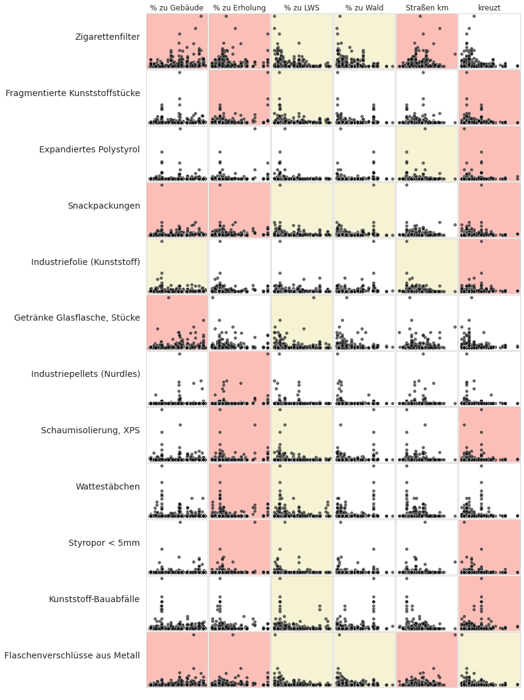

In [26]:
sut.display_image_ipython("resources/images/shared_responsibility/land_use_correlation_de_30_0.png", thumb=(1200, 700))

*__Unten:__ 95% Konfidenzintervall des Medianwertes der Datenerhebungen unter den verschiedenen Landnutzungsklassen.* 

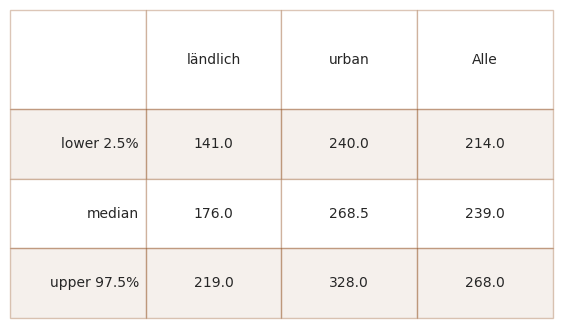

In [27]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)


the_bcas = {}

an_int = 50

# ländlich cis
r_median = grt_dtr[grt_dtr.rural == 'ländlich'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'ländlich'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
r_cis = {'ländlich':{"lower 2.5%":a_result[0], "median":r_median, "upper 97.5%": a_result[1] }}
the_bcas.update(r_cis)

# urban cis
u_median = grt_dtr[grt_dtr.rural == 'urban'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'urban'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
u_cis = {'urban':{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}
the_bcas.update(u_cis)

# all surveys
u_median = grt_dtr[unit_label].median()
a_result = compute_bca_ci(grt_dtr[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
all_cis = {"Alle":{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}

# combine the results:
the_bcas.update(all_cis)

# make a df
the_cis = pd.DataFrame(the_bcas)
the_cis.reset_index(inplace=True)

fig, axs = plt.subplots(figsize=(7,4))

data = the_cis.values
collabels = the_cis.columns
sut.hide_spines_ticks_grids(axs)

the_table = sut.make_a_table(axs, data, colLabels=collabels, colWidths=[*[.2]*5], bbox=[0, 0, 1, 1])
the_table.get_celld()[(0,0)].get_text().set_text(" ")


plt.show()
plt.close()

*__Unten:__ Die Erhebungsergebnisseder am häufigsten vorkommenden Objekte unter den beiden verschiedenen Landnutzungsklassen.*

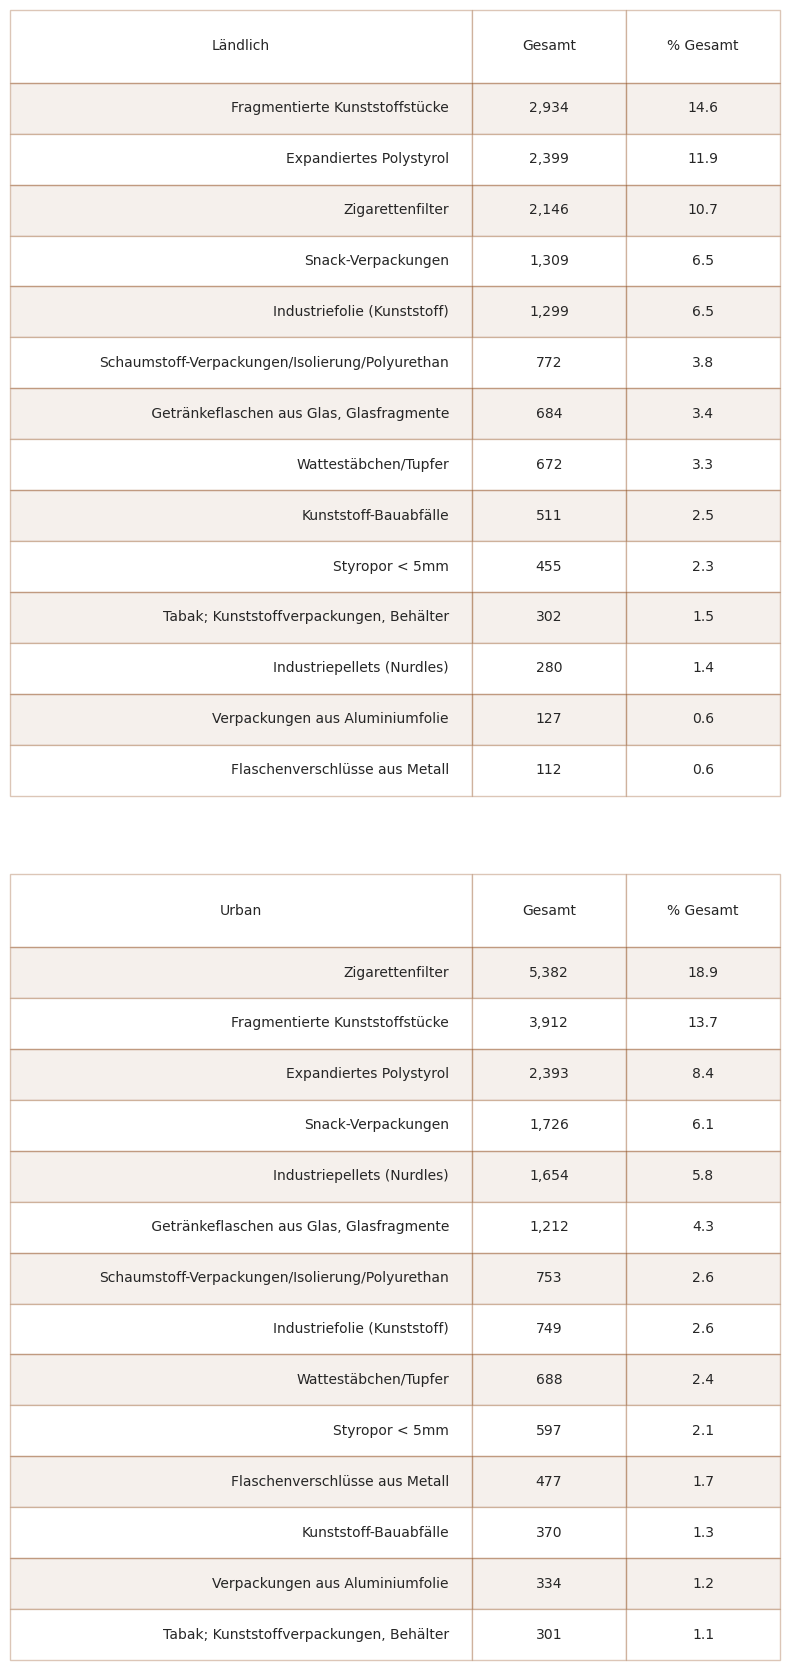

In [28]:
rur_10 = fd[(fd.rural == 'ländlich')&(fd.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)
urb_10 = fd[(fd.rural == 'urban')&(fd.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)

rur_tot = fd[fd.location.isin(rural)].quantity.sum()
urb_tot = fd[fd.location.isin(urban)].quantity.sum()

rur_10['item'] = rur_10.code.map(lambda x: code_description_map.loc[x])
urb_10['item'] = urb_10.code.map(lambda x: code_description_map.loc[x])

rur_10["% of total"] = ((rur_10.quantity/rur_tot)*100).round(1)
urb_10["% of total"] = ((urb_10.quantity/urb_tot)*100).round(1)

# make tables
fig, axs = plt.subplots(2,1, figsize=(8,(len(most_common)*.6)*2))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs[0]
axtwo = axs[1]

sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)
new_col_names = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt"}
data_one = rur_10[['item', 'quantity', "% of total"]].copy()
data_one.rename(columns=new_col_names, inplace=True)
data_two = urb_10[['item', 'quantity', "% of total"]].copy()
data_two.rename(columns=new_col_names, inplace=True)

for a_df in [data_one, data_two]:
    a_df["Gesamt"] = a_df["Gesamt"].map(lambda x: F"{x:,}")

first_table = sut.make_a_table(axone, data_one.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
first_table.get_celld()[(0,0)].get_text().set_text("Ländlich")


a_table = sut.make_a_table(axtwo, data_two.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
a_table.get_celld()[(0,0)].get_text().set_text("Urban")

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

### Saisonale Schwankungen

Saisonale Schwankungen der Ergebnisse von Strand-Abfallaufkommen Untersuchungen sind unter verschiedenen Bedingungen und Umgebungen dokumentiert worden. Im Jahr 2018 meldete der SLR {cite}`slr` den Höchstwert im Juli und den Mindestwert im November. Für das Jahr 2020-2021 liegen die gleichen Ergebnisse vor. 

*__Unten:__ monatliche Erhebungsergebnisseund Abflussmengen m³/Sekunde*

*April und Mai 2021 sind gleitende Durchschnitte, Daten nicht verfügbar*

*source : https://www.hydrodaten.admin.ch/en/stations-and-data.html?entrance_medium=menu*

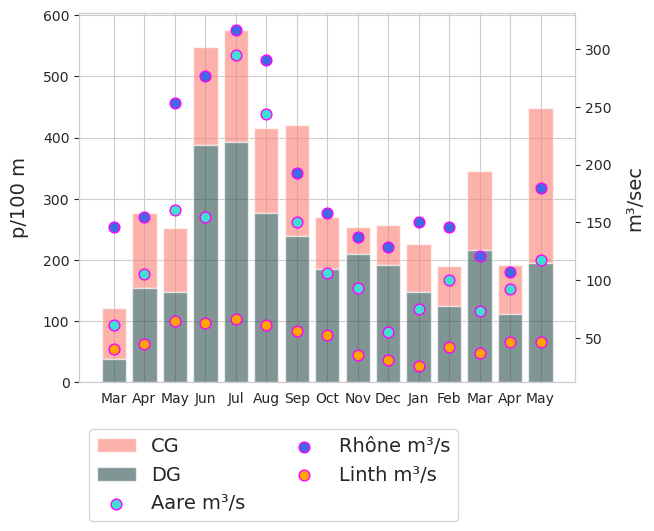

In [29]:
# the survey results to test
corr_data = fd[(fd.code.isin(most_common))].copy()
results_sprmns = {}
for i,code in enumerate(most_common):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        corr, a_p = stats.spearmanr(data[n], data[unit_label])
        results_sprmns.update({code:{"rho":corr, 'p':a_p}})

# helper dict for converting ints to months
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

m_dt = fd.groupby(['loc_date', 'date','group'], as_index=False).agg({'quantity':'sum', unit_label:'sum'})

# sample totals all objects
m_dt_t = fd.groupby(['loc_date','date','month', 'eom'], as_index=False).agg({unit_label:'sum'})
m_dt_t.set_index('date', inplace=True)

# data montlhy median survey results contributed, distributed and survey total
fxi=m_dt.set_index('date', drop=True)
data1 = fxi[fxi.group == CG][unit_label].resample("M").mean()
data2 = fxi[fxi.group == DG][unit_label].resample("M").mean()

# helper tool for months in integer order
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

# the monthly average discharge rate of the three rivers where the majority of the samples are
aare_schonau = [61.9, 53, 61.5, 105, 161, 155, 295, 244, 150, 106, 93, 55.2, 74.6, 100, 73.6, 92.1]
rhone_scex =   [152, 144, 146, 155, 253, 277, 317, 291, 193, 158, 137, 129, 150, 146, 121, 107]
linth_weesen = [25.3, 50.7, 40.3, 44.3, 64.5, 63.2, 66.2, 61.5, 55.9, 52.5, 35.2, 30.5, 26.1, 42.0, 36.9]

fig, ax = plt.subplots()
    
this_x = [i for i,x in  enumerate(data1.index)]
this_month = [x.month for i,x in enumerate(data1.index)]

twin_ax = ax.twinx()
twin_ax.grid(None)

ax.bar(this_x, data1.to_numpy(), label='CG', bottom=data2.to_numpy(), linewidth=1, color="salmon", alpha=0.6)
ax.bar([i for i,x in  enumerate(data2.index)], data2.to_numpy(), label='DG', linewidth=1,color="darkslategray", alpha=0.6)

sns.scatterplot(x=this_x,y=[*aare_schonau[2:], np.mean(aare_schonau)], color='turquoise',  edgecolor='magenta', linewidth=1, s=60, label='Aare m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*rhone_scex[2:], np.mean(rhone_scex)], color='royalblue',  edgecolor='magenta', linewidth=1, s=60, label='Rhône m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*linth_weesen[2:], np.mean(linth_weesen), np.mean(linth_weesen)], color='orange', edgecolor='magenta', linewidth=1, s=60, label='Linth m³/s', ax=twin_ax)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = twin_ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

ax.set_ylabel(unit_label, **ck.xlab_k14)
twin_ax.set_ylabel("m³/sec", **ck.xlab_k14)

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]

plt.xticks(ticks=axisticks, labels=labelsx)
plt.legend([*handles, *handles2], [*labels, *labels2], bbox_to_anchor=(0,-.1), loc='upper left', ncol=2, fontsize=14)

plt.show()

## Die Erhebungsergebnissevon FP und FT in Bezug auf die Landnutzung

__FP__ = Fragmentierte Kunststoffstücke und Geschäumte Kunststoffe

__FT__ = Zigaretten und Snack-Verpackungen

__Ergebnisse von KS-Test und Mann Whitney U__

Die Erhebungsergebnissefür FP Objekte sind sehr ähnlich bis zu $\approxeq$  das 85. Perzentil, wo die Erhebungsergebnisseauf dem Land deutlich höher sind. Das deutet darauf hin, dass extreme Werte für FP in ländlichen Gebieten wahrscheinlicher waren. Nach dem KS-Test (ks=0,78, pvalue=0,69) und dem MWU-Test (U=10624, pvalue=0,40) ist die Verteilung der FP-Objekte unter den beiden Landnutzungsklassen nicht signifikant unterschiedlich und könnte gleich sein.  

Die Erhebungsergebnissefür FT-Objekte behalten die gleichen Merkmale wie die der übergeordneten Verteilung. Die Ergebnisse des KS-Tests (ks=0,29, pWert<.001) und des MWU-Tests (U=7356,5, p<.001) stimmen mit den Ergebnissen der Elterngruppe überein, dass es einen statistisch relevanten Unterschied zwischen den Datenerhebungen Ergebnissen unter verschiedenen Landnutzungsklassen gibt.  

*__Links:__ Land - Stadt: ECDF der Erhebungsergebnissefragmentierte Kunststoffe und Schaumstoffe (FP)* 

*__Rechts:__ Land - Stadt: ECDF der ErhebungsergebnisseZigarettenstummel und Bonbonverpackungen (FT)*

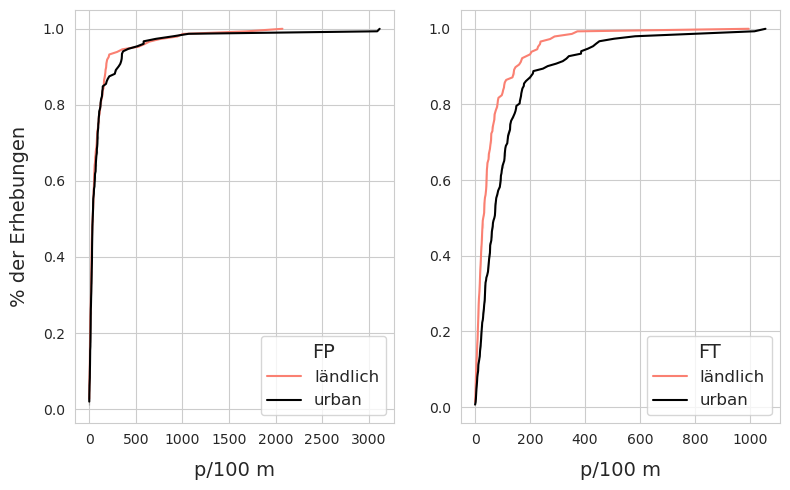

In [30]:
agg_dobj = fd[(fd.rural == 'ländlich')&(fd.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values
buld_obj = fd[(fd.rural == 'urban')&(fd.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values

a_d_ecdf = ECDF(agg_dobj)
b_d_ecdf = ECDF(buld_obj)

agg_cont = fd[(fd.rural == 'ländlich')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values
b_cont = fd[(fd.rural == 'urban')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values

a_c_ecdf = ECDF(agg_cont)
b_c_ecdf = ECDF(b_cont)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="ländlich", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel('% der Erhebungen', **ck.xlab_k14)

axone.legend(fontsize=12, title='FP',title_fontsize=14)

axtwo = ax[1]
sns.lineplot(x=a_c_ecdf.x, y=a_c_ecdf.y, color='salmon', label="ländlich", ax=axtwo)
sns.lineplot(x=b_c_ecdf.x, y=b_c_ecdf.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')

axtwo.legend(fontsize=12, title='FT',title_fontsize=14)

plt.tight_layout()

plt.show()

### FP und FT Differenz der Mittelwerte.

Das durchschnittliche Datenerhebungsergebnis von FP-Objekten in ländlichen Gebieten lag bei 22,93p/50m in städtischen Gebieten bei 12p/50m. Es wurde ein Permutationstest auf die Differenz der Mittelwerte unter der Bedingung ländlich - städtisch durchgeführt. 

Differenz der Mittelwerte von fragmentierten Schaumstoffen und Kunststoffen unter den beiden verschiedenen Landnutzungsklassen. *$\mu_{ländlich}$*  - $\mu_{urban}$, method=shuffle, permutations=5000*

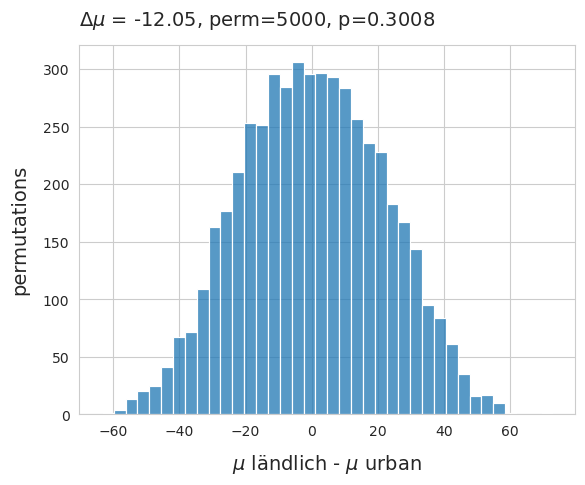

In [31]:
# pemutation test: of difference of means FP objects
agg_dobj = fd[(fd.rural == 'ländlich')&(fd.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
buld_obj = fd[(fd.rural == 'urban')&(fd.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_dobj['class'] = 'ländlich'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = pd.concat([agg_dobj, buld_obj])

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['ländlich'] - the_mean.loc['urban']
new_means=[]

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['ländlich'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['ländlich'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ ländlich - $\mu$ urban", **ck.xlab_k14)
plt.show()

*__Oben:__ Verwerfen Sie die Nullhypothese: Es gibt keinen statistisch signifikanten Unterschied zwischen den beiden Verteilungen* 
    
*__Unten:__ Differenz der Mittelwerte für Zigarettenstummel und Snackverpackungen unter den beiden verschiedenen Landnutzungsklassen.* 

*$\mu_{länd;ich}$ - $\mu_{urban}$, method=shuffle, permutations=5000*

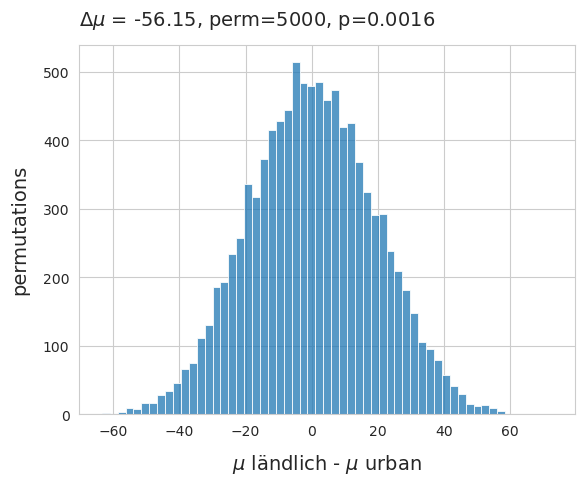

In [32]:
# pemutation test: of difference of means food objects
agg_cont = fd[(fd.rural == 'ländlich')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
b_cont = fd[(fd.rural == 'urban')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_cont['class'] = 'ländlich'
b_cont['class'] = 'urban'

# merge into one 
objs_merged = pd.concat([agg_cont, b_cont])

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['ländlich'] - the_mean.loc['urban']

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['ländlich'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['ländlich'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ ländlich - $\mu$ urban", **ck.xlab_k14)
plt.show()

*__Oben:__ Verwerfen Sie die Nullhypothese: die beiden Verteilungen sind höchstwahrscheinlich nicht identisch.*

In [33]:
# a set of map points with the median survey value for each of the most 
# common codes and median survey value of DG and CG
a_maps = fd[(fd.code.isin(most_common))].groupby(['loc_date','location', 'code'], as_index=False)[unit_label].sum()

# median survey result for each code at each location
a_map = a_maps.groupby(['location', 'code'], as_index=False)[unit_label].median()

# pivot that and get codes as columns
som_vals = a_map.pivot(columns=['code'], index='location', values=unit_label)

# the median survey value of DG objects at each location
dgt = a_maps[a_maps.code.isin(dist)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
dgt = dgt.groupby('location')[unit_label].median()

# the median survey value of CG objects at each location
cgt = a_maps[a_maps.code.isin(cont)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
cgt = cgt.groupby('location')[unit_label].median()

# add columns to som_vals
som_vals['DG'] = som_vals.index.map(lambda x: dgt.loc[x])
som_vals['CG'] = som_vals.index.map(lambda x: cgt.loc[x])

these_beaches = dfBeaches.loc[som_vals.index][['latitude','longitude', 'bfsnum', 'city']]
a_map = pd.concat([these_beaches, som_vals], axis=1)
# a_map.to_csv(F"{project_directory}/causality.csv")